# Droplets

This *jupyter* notebook carries out the analyses in the upcoming journal article focusing on analyzing gravitationally unbound, coherent structures with significant velocity gradients.  The notebook is edited to work with data and *Python* scripts in the [Github repo](https://github.com/hopehhchen/Droplets).

## 0. Abstract and Outlines

The project looks for coherent cores with significant velocity gradients in the L1688 region in Ophiuchus and the B18 region in Taurus, out of the four nearby star forming regions covered by the *GBT Ammonia Survey* (GAS) Data Release 1 ([Friesen and Pineda et al., 2017](https://ui.adsabs.harvard.edu/#abs/2017ApJ...843...63F/abstract)).  One goal of the project is to update numbers for physical properties of (potentially) rotational motions within these structures.  The relation between the velocity gradient and the size was first examined using observations of ammonia molecular line emission by [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract).  With an improved physical resolution of ~4000 AU (the FWHM beam size at the distance of Ophiuchus and Taurus), we hope to provide more reliable and relevant numbers for simulations and analytical models, especially ones concerning with disk formation inside star forming cores.

Subsequent analyses included in this project discover that the structures are possibly gravitationally unbound, despite subsonic velocity dispersions and relatively high column densities.  The behavior is unexpected in the final stages of monolithic star formation driven by gravity.  Due to their small sizes and the seeming unboundness, we term these structures "droplets," to distinguish them from "cores," which are often used to indicate bound and star forming, sub-parsec structures.  The project aims at providing a guess to how the "droplets" are formed and what role they could play in the star formation process.

This notebook is organized as follows. In [***I. Identification of Structures***](#identification), we go through how we identify these structures and how we define the boundaries.  In [***II. Physical Properties of Droplets***](#properties), we derive the basic physical properties of the "droplets," based on the property maps from ammonia line fitting to the GAS DR1 data.  In ***III. Kinematics and Dynamics***, we look for possible explanations to the formation of "droplets" and the role they play in star formation.  In particular, we look into the spatial distribution of ram pressure within and around the "droplets," to see whether the droplets could be pressure-bound.  In all sections of this notebook, we also provide the codes to generate tables and plots that eventually appear in the corresponding parts of the article.

Further discussions are included in the article hosted on Authorea.  **This notebook, though filled with definitions essential for users to understand the analyses, is *not* meant to be complete or continuous as the journal article itself.**  Please look in the article for details.

***CAUTION: This is work in progress.***

[*The square brackets in this notebook host the technical explanations of following code cells.  They should be treated as code comments.*]

#### Authors
* **Hope Chen** (leading and corresponding, at <hhchen@cfa.harvard.edu>; Harvard-Smithsonian Center for Astrophysics)
* Jaime Pineda (Max-Planck-Institut für Extraterrestrische Physik)
* Alyssa Goodman (Harvard-Smithsonian Center for Astrophysics)
* Andreas Burkert (University Observatory Munich)

#### Code Dependencies
The version numbers listed below correspond to the versions used when this notebook is compiled.  Most *Python* packages are backward compatible, but there is no guarantee.  Please report problems via [the issue tracker of the Droplet repo](https://github.com/hopehhchen/Droplets/issues).
* `numpy`: v1.13.1
* `scipy`: v0.19.1
* `astropy`: v2.0.2
* `FITS_tools`: v0.0.dev
* `matplotlib`: v2.0.2
* `pandas`: v0.20.3

In [1]:
%matplotlib inline
import sys
import os

#
import numpy as np
import scipy

#
from astropy.io import fits
import astropy.wcs as wcs
import astropy.units as u
import astropy.constants as c
import FITS_tools as fits_tools

#
import matplotlib.pyplot as plt
import matplotlib.colors as colors
#from matplotlib import rcParams

#
import pandas as pd

## 
from Droplets import *
from constants import *
import styles

#### Main Variables in this Notebook
The variables are derived along the way following the steps outlined above.  This list is just for bookkeeping.  (The attached link goes to the code cell where each variable is first defined.)
* [`dict_data`](#dict_data): The *Python* dictionary that stores the maps in "`./data/`".  The data are from the GAS DR1 ([Friesen and Pineda et al., 2017](https://ui.adsabs.harvard.edu/#abs/2017ApJ...843...63F/abstract)), with the original files stored in [this dataverse](https://dataverse.harvard.edu/dataverse/GAS_Project).
* [`dict_masks`](#dict_masks): The *Python* dictionary that stores the masks for the target structures in "`./results/masks/`".
* [`dict_YSOs`](#dict_YSOs): The *Python* dictionary that sotres the YSO catalogs in "`./data/YSO_catalogs/`".  The catalogs are originally from [Dunham et al. (2015)](https://ui.adsabs.harvard.edu/#abs/2015ApJS..220...11D/abstract) and [Rebull et al. (2010)](https://ui.adsabs.harvard.edu/#abs/2010ApJS..186..259R/abstract), and include only Class 0/I and flat spectrum YSOs above certain "grades" assigned in the original works.  The original catalogs can be found on VizieR: [catalogs in Dunham et al. (2015)](http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/ApJS/220/11) and [catalogs in Rebull et al. (2010)](http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/ApJS/186/259).
* [`dict_Vlsr_predicted`](#dict_Vlsr_predicted): The *Python* dictionary that stores the maps of predicted $V_\text{LSR}$ based on the velocity gradient fits, in "`./results/Vlsr_predicted/`".  Details about fitting of $V_\text{LSR}$ can be found in [***II. Physical Properties of Droplets***](#properties).

### 0.1 Data and Targets

The GAS DR1 inlcudes observations of the ammonia hyperfine line emission made with the *Green Bank Telescope* (GBT).  By fitting Guassian profiles to the ammonia hyperfine lines, [Friesen and Pineda et al. (2017)](https://ui.adsabs.harvard.edu/#abs/2017ApJ...843...63F/abstract) derive the property maps of four nearby star forming regions: B18 in Taurus, L1688 in Ophiuchus, NGC1333 in Perseus, and Orion A North.  These physical properties include the NH$_3$ velocity centroid (in the LSR frame; $V_\text{LSR}$), the NH$_3$ velocity dispersion ($\sigma_V$), the NH$_3$ column density ($N_{\text{NH}_3}$), the excitation temperature of NH$_3$ hyperfine lines ($T_\text{ex}$), and the kinetic temperature ($T_\text{kin}$).  Besides property maps included as part of the GAS DR1, we also derive the peak main beam temperature from the trimmed and baseline subtracted data cubes from observations of NH$_3$ (1, 1) hyperfine lines.  We look for coherent structures using these physical properties in the B18 region and the L1688 region, where their proximity (at the distances of ~135 and ~137.3 pc, respectively; [Schlafly et al., 2014](https://ui.adsabs.harvard.edu/#abs/2014ApJ...786...29S/abstract); [Ortiz-León et al., 2017](https://ui.adsabs.harvard.edu/#abs/2017ApJ...834..141O/abstract)) grants us the highest physical resolution (the GBT FWHM beamsize of 32" at 23 GHz corresponds to ~4300 AU).

[*The Python dictionary `distances` stores the distances that are used throughout this paper, in the formats of `astropy.units`.  The code cell below is for demonstrative purpose; for a complete list of constants used in this paper, see [`constants.py`](https://github.com/hopehhchen/Droplets/blob/master/Droplets/constants.py).*]

In [2]:
distances = {'L1688': 137.3*u.pc, 'B18': 135.*u.pc}

The GAS data are supplemented by the column density and dust temprature maps derived using *Herschel* observations of dust continuum emission.  The *Herschel* observations were made as part of the *Herschel Gould Belt Survey* (GBS; [André et al., 2010](https://ui.adsabs.harvard.edu/#abs/2010A&A...518L.102A/abstract)), and the data are from the *Herschel* Science Archive.  Ayushi Singh and Peter Martin at University of Toronto derived maps of the optical depth and the dust temperature by fitting the SED from the SPIRE observations to opaticy corrected blackbody emission ("gray-body emission"; [Hildebrand, 1983](https://ui.adsabs.harvard.edu/#abs/1983QJRAS..24..267H/abstract)).  Singh and Martin assumed a dust opacity at 1 THz ($\kappa_\text{1THz}$) of 10 cm$^2$ g$^{-1}$ with a power-law dependence on the frequency to the order of $\beta = 1.62$, and also a gas to dust ratio of 100.  The resulting maps can be found in the [github `./data/Herschel/` folder](https://github.com/hopehhchen/Droplets/tree/master/Droplets/data/Herschel), with key parameters used in the SED fitting accessible in the FITS headers.  The FWHM beamsize of SPIRE 500 µm is 36", which matches well with the GBT beamsize.

The full GAS DR1 dataset is hosted on [Dataverse](https://dataverse.harvard.edu/dataverse/GAS_Project), which includes the original data cubes from GBT observations of various molecular lines.  The peak main beam temperature maps were not included in the set of property maps in the GAS DR1, but were instead derived from the trimmed and baseline subtracted data cubes.  Due to the github policy for large data files, the  [Droplets github repo](https://github.com/hopehhchen/Droplets) includes only the data maps that are needed in the analyses, but not the data cubes from which the property maps were derived.

[*The datasets are read and stored in `dict_data`.  The maps of error in each phsyical property were produced for the GAS DR1 alongside the property maps, and are stored in `dict_data` with a prefix "`e`".  The property maps in the GAS DR1 are flagged by the detection level and the goodness of the fit.  In the array directly read in from files in [this github repo](https://github.com/hopehhchen/Droplets) and in the [GAS DR1 dataverse](https://dataverse.harvard.edu/dataverse/GAS_Project), the flagged pixels within the observed areas have values of 0.  In the following code cell, we remove the flags by converting them to NaN values, for the ease of future calculation.  This is not done for the maps of the peak main beam temperature, which is derived from the data cubes that include the full observed areas.*]
<a id='dict_data'></a>

In [2]:
# data folder (within the current directory)
direcData = os.getcwd()+'/data/'
## lists of property maps to be read in
list_propertiesGAS = ['Vlsr', 'Sigma', 'N_NH3', 'Tex', 'Tkin']
list_propertiesHerschel = ['colden', 'temp']


# Read the data.
dict_data = {'L1688': {}, 'B18': {}}
for reg in ['L1688', 'B18']:
    
    # GAS DR1 Property Maps
    for prop in list_propertiesGAS:
        ## data
        data = fits.open(direcData+'GAS_DR1/'+reg+'/'+reg+'_'+prop+'_DR1_rebase3_flag.fits')[0].data
        data[data == 0.] = np.nan ## Remove the flags
        dict_data[reg][prop] = data
        
        ## error maps
        data = fits.open(direcData+'GAS_DR1/'+reg+'/'+reg+'_e'+prop+'_DR1_rebase3_flag.fits')[0].data
        data[data == 0.] = np.nan ## Remove the flags
        dict_data[reg]['e'+prop] = data
    ## header
    dict_data[reg]['header_GAS'] = fits.open(direcData+'GAS_DR1/'+reg+'/'+reg+'_Vlsr_DR1_rebase3_flag.fits')[0].header
    
    # GAS DR1 Peak Main Beam Temperature
    dict_data[reg]['Tpeak'] = fits.open(direcData+'GAS_DR1/'+reg+'/'+reg+'_Tpeak_DR1_rebase3_trim.fits')[0].data
    
    # Herschel
    for prop in list_propertiesHerschel:
        ## data
        dict_data[reg][prop] = fits.open(direcData+'Herschel/'+reg+'/'+reg+'_'+prop+'_masked.fits')[0].data
        
        ## error maps
        dict_data[reg]['e'+prop] = fits.open(direcData+'Herschel/'+reg+'/'+reg+'_'+prop+'_err_masked.fits')[0].data
    ## header
    dict_data[reg]['header_Herschel'] = fits.open(direcData+'Herschel/'+reg+'/'+reg+'_colden_masked.fits')[0].header

Several properties that are immediately derivable from the property maps include the total velocity dispersion ($\sigma_\text{tot}$) and its thermal and non-thermal components ($\sigma_\text{T}$ and $\sigma_\text{NT}$, respectively).  These can be derived from the NH$_3$ linewidth ($\sigma_{\text{NH}_3}$) and the kinetic temperature of the gas ($T_\text{kin}$), assuming that different species of molecules are at a thermal equilibrium.  The equation used here is: $$\sigma_\text{tot}^2 = \sigma_{\text{NH}_3}^2 - \frac{k_B T_\text{kin}}{m_{\text{NH}_3}} + \frac{k_B T_\text{kin}}{\mu m_\text{H}} \text{,}$$ where $m_{\text{NH}_3}$ is the molecular weight of NH$_3$ and $\mu m_\text{H}$ is the average particle weight in the atomic mass unit (a.m.u.).  Throughout this paper, we use $\mu = 2.37$ based on the results presented by [Kauffmann et al. (2008)](https://ui.adsabs.harvard.edu/#abs/2008A&A...487..993K/abstract), and $m_{\text{NH}_3} = 17.031\ \text{a.m.u.}$ according to the [IUPAC value](https://pubchem.ncbi.nlm.nih.gov/compound/ammonia#section=Top).

[*The derived properties: $\sigma_\text{tot}$, $\sigma_\text{T}$, and $\sigma_\text{NT}$ are stored in the same dictionary: `dict_data`.  The following code cell might generate a `RuntimeWarning` regarding invalid value encoutered in sqrt, which by default would simply produce a NaN value at the pixel(s).  The warning message is due to the unlikely event where the observed NH$_3$ linewidth is narrower than the thermal linewidth of the NH$_3$ molecules expected at the observed kinetic temperature.  This happens only at ~0.01% of the sky areas observed in the L1688 and B18 regions combined.  The definition of the variable `mass` below is merely for demonstrative purpose.  For the full list of constants used in this paper, see [`constants.py`](https://github.com/hopehhchen/Droplets/blob/master/Droplets/constants.py).*]

In [3]:
# mass for the NH3 molecule and an average particle in ISM
mass = {'NH3': 17.031*u.u, 'average': 2.37*u.u}


# Derive the total velocity dispersion, and its thermal and non-thermal components.
for reg in ['L1688', 'B18']:
    
    # NH3 linewidth and kinetic temperature from GAS DR1
    sigmaNH3 = dict_data[reg]['Sigma']
    Tkin = dict_data[reg]['Tkin']
    
    
    # derived properties
    ## thermal and non-thermal components
    sigmaNT = np.sqrt((sigmaNH3*u.km/u.s)**2. - c.k_B*Tkin*u.K/mass['NH3']).to(u.km/u.s).value
    sigmaT = np.sqrt(c.k_B*Tkin*u.K/mass['average']).to(u.km/u.s).value
    ## total velocity dispersion
    sigmaTot = np.sqrt((sigmaNT*u.km/u.s)**2.+(sigmaT*u.km/u.s)**2.).to(u.km/u.s).value
    
    
    # store the derived maps
    dict_data[reg]['SigmaNT'] = sigmaNT
    dict_data[reg]['SigmaT'] = sigmaT
    dict_data[reg]['SigmaTot'] = sigmaTot

//anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in sqrt
  *arrays, **kwargs)


For easier comparison between the GAS DR1 data and the *Herschel* maps, we project the *Herschel* maps to the GAS DR1 grid.  As mentioned above, the GBT has a FWHM beamsize at 23 GHz (32") similar to the FWHM beamsize of *Herschel* 500 µm (36").  Thus, we can safely assume that the regridding does not introduce a significant biase.

[*The regridding is done using the *Python* package [`FITS_tools`](http://fits-tools.readthedocs.io/en/latest/fits_tools.html).  The newly projected images replace the original images in `dict_data`.*]

In [4]:
# Regrid the Herschel maps.
for reg in ['L1688', 'B18']:
    
    for prop in list_propertiesHerschel:
        
        # Regrid using hcongrid.
        ## data
        image = dict_data[reg][prop].copy()
        header1 = dict_data[reg]['header_Herschel'] ## original projection
        header2 = dict_data[reg]['header_GAS'] ## projection to interpolate into
        
        dict_data[reg][prop] = fits_tools.hcongrid.hcongrid(image, header1, header2)
        
        ## error maps
        image = dict_data[reg]['e'+prop].copy()
        header1 = dict_data[reg]['header_Herschel'] ## original projection
        header2 = dict_data[reg]['header_GAS'] ## projection to interpolate into
        
        dict_data[reg]['e'+prop] = fits_tools.hcongrid.hcongrid(image, header1, header2)

In the analyses below, we use YSO catalogs from [Dunham et al. (2015)](https://ui.adsabs.harvard.edu/#abs/2015ApJS..220...11D/abstract) and [Rebull et al. (2010)](https://ui.adsabs.harvard.edu/#abs/2010ApJS..186..259R/abstract) to determine the existence of YSO sources potentially associated with target structures in Ophiuchus and in Taurus, respectively.  Parsed versions of the catalogs that include only Class 0/I and flat spectrum YSOs, above certain "grades" of reliability assigned in the papers just mentioned, can be found in [the data folder of this github repo](https://github.com/hopehhchen/Droplets/tree/master/Droplets/data/YSO_catalogs).  The original, full catalogs can be found on [VizieR](http://vizier.u-strasbg.fr/viz-bin/VizieR) on the corresponding catalog pages: [catalogs in Dunham et al. (2015)](http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/ApJS/220/11) and [catalogs in Rebull et al. (2010)](http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/ApJS/186/259).

The parsed versions of the catalogs include only Class 0/I and flat spectrum YSOs (according to the definitions in the corresponding papers mentioned above), which are not AGBs in [Dunham et al. (2015)](https://ui.adsabs.harvard.edu/#abs/2015ApJS..220...11D/abstract) nor below the rank "A-" in [Rebull et al. (2010)](https://ui.adsabs.harvard.edu/#abs/2010ApJS..186..259R/abstract).  There is information about the coordinates, the object names in the original surveys, and the classification in the catalogs.  In the case of [`L1688.csv`](https://github.com/hopehhchen/Droplets/blob/master/Droplets/data/YSO_catalogs/L1688.csv), the column "`alpha_prime`" corresponds to the extinction corrected spectral index, $\alpha^\prime$, in [Dunham et al. (2015)](https://ui.adsabs.harvard.edu/#abs/2015ApJS..220...11D/abstract), and is used to determine the class of the YSOs.  According to [Dunham et al. (2015)](https://ui.adsabs.harvard.edu/#abs/2015ApJS..220...11D/abstract), YSOs with $\alpha^\prime \geq 0.3$ belong to Class 0/I, and YSOs with $0.3 > \alpha^\prime \geq -0.3$ belong to the "flat spectrum" category.

[*Since only the pixel coordinates on the GAS data projection are needed, the celetial coordinates are converted using the GAS headers before being stored in `dict_YSOs`.  The resulting array of pixel coordinates has a length of the number of YSOs in the catalog and a width of two corresponding to the x (Axis 1 in a numpy array) and the y (Axis 0 in a numpy array) coordinates.*]
<a id='dict_YSOs'></a>

In [5]:
# data folder (within the current directory)
direcData = os.getcwd()+'/data/'

# Read the data.
dict_YSOs = {}
for reg in ['L1688', 'B18']:
    
    ## catalogs
    catalog = pd.read_csv(direcData+'YSO_catalogs/'+reg+'.csv')
    
    ## header used for converting YSO coordinates to pixel coordinates
    header = dict_data[reg]['header_GAS']
    
    ## Convert YSO coordinates to pixel coordinates
    projection = wcs.WCS(header)
    dict_YSOs[reg] = projection.wcs_world2pix(np.c_[catalog['RA'].values, catalog['Dec'].values], 0)

### 0.2 Sources from [*Goodman et al. (1993)*](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract)

[Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract) presented a survey of 43 sources with observations of NH$_3$ line emission (see the [SIMBAD obejct list](http://simbad.harvard.edu/simbad/sim-ref?querymethod=bib&simbo=on&submit=submit+bibcode&bibcode=1993ApJ...406..528G); several objects are associated with different SIMBAD identifiers than in the paper).  The properties of the sources are summarized in Table 1 and Table 2 of the paper.  Unfortunately, no digitization exists for the paper and the tables, so we manually duplicate the two tables, and the results can be found in the [github `./data/Goodman93/` folder](https://github.com/hopehhchen/Droplets/tree/master/Droplets/data/Goodman93).

In [6]:
direcData = os.getcwd()+'/data/Goodman93/'
table1 = pd.read_csv(direcData+'table1.csv',
                     index_col = False)
table2 = pd.read_csv(direcData+'table2.csv',
                     index_col = False)

To compare the properties of the 43 sources observed by [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract), we update the tables with 1) peak positions in the FK5 J2000.0 frame, 2) updated mass of average particles (2.37 a.m.u.; [Kauffmann et al., 2008](https://ui.adsabs.harvard.edu/#abs/2008A&A...487..993K/abstract)), 3) updated measurements of distances, and 4) updated derived properties based on the new particle weight and distances.  The updated distances are summarized below:

1. Regions associated with the molecular cloud in Perseus: **PER3**, **PER6**, and **B5**.  We adopt distances measured by [Schlafly et al. (2014)](https://ui.adsabs.harvard.edu/#abs/2014ApJ...786...29S/abstract) using *PanSTARRS-1* photometry, which are 315±32 pc for the western part of the Perseus molecular cloud (including PER3 and PER6) and 260±26 pc for the eastern part (including B5).

2. Regions associated with the molecular cloud in Taurus: **L1489**, **L1498**, **L1495**, **L1495NW**, **L1495SE**, **TAU11**, **TAU16**, **B217**, **L1524**, **TMC-2A**, **L1534** (TMC-1A), **L1527**, **TMC-1C**, and **L1517B**.  We adopt a distance of 135±20 pc, measured by [Schlafly et al. (2014)](https://ui.adsabs.harvard.edu/#abs/2014ApJ...786...29S/abstract).

3. Regions associated with $\lambda$ Orionis: **L1582A** and **B35A**.  We adopt a distance of 420±42 pc, measured by [Schlafly et al. (2014)](https://ui.adsabs.harvard.edu/#abs/2014ApJ...786...29S/abstract).

4. A region associated with the molecular cloud and the YSO cluster in Ophiuchus (sometimes under the name of $\rho$ Oph): **L1696A**.  We adopt a distance of 137.3±6 pc, measured by [Ortiz-León et al. (2017)](https://ui.adsabs.harvard.edu/#abs/2017ApJ...834..141O/abstract) using parallax.

5. Regions associated with clouds and clumps in Oph N: **L43/RNO90**, **L43**, **L260** (a.k.a. L255), **L158**, **L234E**, **L234A**, and **L63**.  These regions are usually associated with the Ophiuchus complex or, on a larger scope, the Upper Sco-Oph-Cen complex.  [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract) adopted the same distance for these regions as for L1696A.  Here we use an updated distance measurement of 125±18 pc to the Ophiuchus complex by [Schlafly et al. (2014)](https://ui.adsabs.harvard.edu/#abs/2014ApJ...786...29S/abstract).  This is in good agreement with the widely used 125±45 pc, measured by [de Geus et al. (1989)](https://ui.adsabs.harvard.edu/#abs/1989A&A...216...44D/abstract).

6. Regions associated with Cepheus Flare: The Cepheus Flare spans more than 10 degrees from North to South on the plane of the sky, and is known to have a complicated structure with multiple concentrations of material at different distances.  Here we adopt distance measurements for different regions in Cepheus Flare, and note that these distances were used by [Kauffmann et al. (2008)](https://ui.adsabs.harvard.edu/?#abs/2008A%26A...487..993K) side-by-side.  Note, however, that [Schlafly et al. (2014)](https://ui.adsabs.harvard.edu/#abs/2014ApJ...786...29S/abstract) measured 360±35 pc for the southern part of Cepheus Flare and 900±90 pc for the northern part of Cepheus Flare.  See discussions in [Schlafly et al. (2014)](https://ui.adsabs.harvard.edu/#abs/2014ApJ...786...29S/abstract).

    a. **L1152**: 325±13 pc, measured by [Straižys et al. (1992)](https://ui.adsabs.harvard.edu/?#abs/1992BaltA...1..149S/abstract) using photometry.
    
    b. **L1082C**, **L1082A**, and **L1082B**: 400±50 pc, measured by [Bourke et al. (1995)](https://ui.adsabs.harvard.edu/?#abs/1995MNRAS.276.1052B/abstract) using photometry.
    
    c. **L1174** and **L1172A**: 288±25 pc, measured by [Straižys et al. (1992)](https://ui.adsabs.harvard.edu/?#abs/1992BaltA...1..149S/abstract) using photometry.
    
    c. **L1251A**, **L1251E**, and **L1262A**: we update the distance used by [Kauffmann et al. (2008)](https://ui.adsabs.harvard.edu/?#abs/2008A%26A...487..993K) based on [Kun (1998; 300$^{+50}_{-10}$ pc)](https://ui.adsabs.harvard.edu/?#abs/1998ApJS..115...59K/abstract) with a more recent measurement of 286±20 pc made by [Zdanavičius et al. (2011)](https://ui.adsabs.harvard.edu/#abs/2011BaltA..20..317Z/abstract) using photometry.
    
7. Other regions with distances measured from masers:

    a. **L1400G** and **L1400K**: 170±50 pc, measured by [Montillaud et al. (2015)](https://ui.adsabs.harvard.edu/?#abs/2015A%26A...584A..92M).
    
    b. **L134A**: 110±10 pc, measured by [Montillaud et al. (2015)](https://ui.adsabs.harvard.edu/?#abs/2015A%26A...584A..92M).
    
8. Regions of which the distances are not updated since 1990s, but are cited recently.  Here we provide a list of the original references and the most recent year when each reference was cited.

    a. **L483**: 200 pc [(Dame & Thaddeus, 1985)](https://ui.adsabs.harvard.edu/#abs/1985ApJ...297..751D/abstract), with citations as recent as 2017.
    
    b. **L778**: 200 pc [(Schneider & Elmegreen, 1979)](https://ui.adsabs.harvard.edu/#abs/1979ApJS...41...87S/abstract), with citations as recent as 2017.
    
    c. **B361**: 350 pc [(Schmidt, 1975)](https://ui.adsabs.harvard.edu/?#abs/1975MNRAS.172..401S/abstract), with citations as recent as 2010.
    
    d. **L1031B**: 900 pc [(Hilton and lahulla, 1995)](https://ui.adsabs.harvard.edu/#abs/1995A&AS..113..325H/abstract), with citations as recent as 2017.
    
And the derived properties are affected by the updates in distance:

1. Mass ($M$): Since the mass was calculated from the number density derived by modeling the radiative transfer of NH$_3$ line emission, the mass estimates scale with the distance to the cubic order, $M \propto D^3$.

2. Sizes ($r_\text{major}$, $r_\text{minor}$, and $R$): Sizes $\propto D$.

3. The velocity gradient ($\mathcal{G}$): $\mathcal{G} \propto D^{-1}$.

4. The product of the gradient and the radius ($\mathcal{G}\times R$): The product remains unchanged, since the effect of a new distance cancels out.

5. The ratio of rotational and gravitational energies ($\beta$): $\beta \propto \mathcal{G}^2 \propto D^{-2}$.

6. The specific angular momentum ($J/M$): $J/M \propto \mathcal{G}R^2 \propto D$.

Based on these updates, we also create new columns including information on the uncertainty in the distances and the radii used by [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract) in subsequent calculations, which are derived from the geometric mean of the FWHMs along the major and minor axes ($r_\text{major}$ and $r_\text{minor}$): $$R_\text{eff} = \sqrt{r_\text{major}\times r_\text{minor}}\ \ \text{.}$$

Note that values in Table 1 and Table 2 are rounded to the nearest significant digits.  No rounding is done, however, for the updated values below.  This is to guarantee a continuous and consistent conversion over all data points when compared to the properties derived in this paper.  Please use the original tables to find the significant digits when needed.

In [67]:
from astropy.coordinates import SkyCoord, FK4, FK5

table1_updated = table1.copy()

# distance
table1_updated['Distance'] = pd.Series([260., 260., 315., 135., 135., 135., 135., 135., 135., 135.,
                                        170., 135., 135., 170., 135., 135., 135., 135., 135., 420.,
                                        420., 110., 137.3, 125., 125., 125., 125., 125., 125., 125.,
                                        200., 200., 325., 400., 400., 400., 288., 288., 350., 900.,
                                        286., 286., 286.])
## uncertainty in D
table1_updated['eDistance'] = pd.Series([26., 26., 32., 20., 20., 20., 20., 20., 20., 20.,
                                         50., 20., 20., 50., 20., 20., 20., 20., 20., 42.,
                                         42., 10., 6., 45., 45., 45., 45., 45., 45., 45.,
                                         np.nan, np.nan, 13., 50., 50., 50., 25., 25., np.nan, np.nan,
                                         20., 20., 20.])

# coordinates
## RA
table1_updated['RA'] = pd.Series([SkyCoord(ra, dec,
                                           frame = FK4,
                                           equinox = 'B1950').transform_to(FK5(equinox = 'J2000')).ra.deg
                                  for ra, dec in zip(table1['RA'], table1['Dec'])])
## Dec
table1_updated['Dec'] = pd.Series([SkyCoord(ra, dec,
                                            frame = FK4,
                                            equinox = 'B1950').transform_to(FK5(equinox = 'J2000')).dec.deg
                                   for ra, dec in zip(table1['RA'], table1['Dec'])])

# Sigma and Tkin
# SigmaTot
table1_updated['SigmaTot'] = table1['FWHMTot']/(2.*np.sqrt(2.*np.log(2.)))
# Tkin
table1_updated['Tkin'] = pd.Series([11., 11., 10.8, 9.5, 10., np.nan, 10., np.nan, np.nan, np.nan,
                                    10.2, 15., 8.8, 10.8, 10., 8.0, 11.1, 8.9, 11.1, 14.7,
                                    16.6, 9.0, 15., np.nan, 8.5, 8.8, 11.6, 14.5, 10.3, 9.7,
                                    np.nan, 11.2, 10.4, 9.2, 10., 10., 10., 14.2, 10., 12.5,
                                    10.5, np.nan, 10.3])
# SigmaNH3
table1_updated['SigmaNH3'] = pd.Series([.39, .31, .34, .28, .21, .23, .29, np.nan, np.nan, np.nan,
                                        .30, .34, .46, .26, .32, .34, .28, .24, .23, .44,
                                        .82, .32, .26, np.nan, .32, .21, .29, .30, .23, .26,
                                        np.nan, .40, .33, .36, .40, .27, .74, .43, .70, .94,
                                        .37, np.nan, .37])/(2.*np.sqrt(2.*np.log(2.)))
table1_updated['SigmaNH3'] = np.around(table1_updated['SigmaNH3'],
                                       decimals = 2)
# SigmaT and SigmaNT


# mass
table1_updated['M'] = table1['M']*(2.37/2.33)*(table1_updated['Distance']/table1['Distance'])**3.

# sizes
## major FWHM
table1_updated['major'] = table1['major']*(table1_updated['Distance']/table1['Distance'])
## minor FWHM
table1_updated['minor'] = table1['minor']*(table1_updated['Distance']/table1['Distance'])
## R
table1_updated['R'] = np.sqrt(table1_updated['major']*table1_updated['minor'])


# Reorder the columns.
col_list = ['ID', 'Distance', 'eDistance', 'RA', 'Dec',
            'Vlsr', 'SigmaTot', 'M', 'major', 'minor',
            'R', 'PA', 'AspectRatio', 'Tkin', 'SigmaNH3']
table1_updated = table1_updated[col_list]


# Save to the folder.
direcData = os.getcwd()+'/data/Goodman93/'
table1_updated.to_csv(direcData+'table1_updated.csv',
                      index = False)


In [68]:
SigmaNH3 = table1_updated['SigmaNH3'].values
Tkin = table1_updated['Tkin'].values

SigmaTot0 = table1_updated['SigmaTot'].values
SigmaTot1 = np.sqrt((SigmaNH3*u.km/u.s)**2.
                    -c.k_B*Tkin*u.K/mass['NH3']
                    +c.k_B*Tkin*u.K/(2.33*u.u)).to(u.km/u.s).value
SigmaTot2 = np.sqrt((SigmaNH3*u.km/u.s)**2.
                    -c.k_B*Tkin*u.K/mass['NH3']
                    +c.k_B*Tkin*u.K/mass['average']).to(u.km/u.s).value

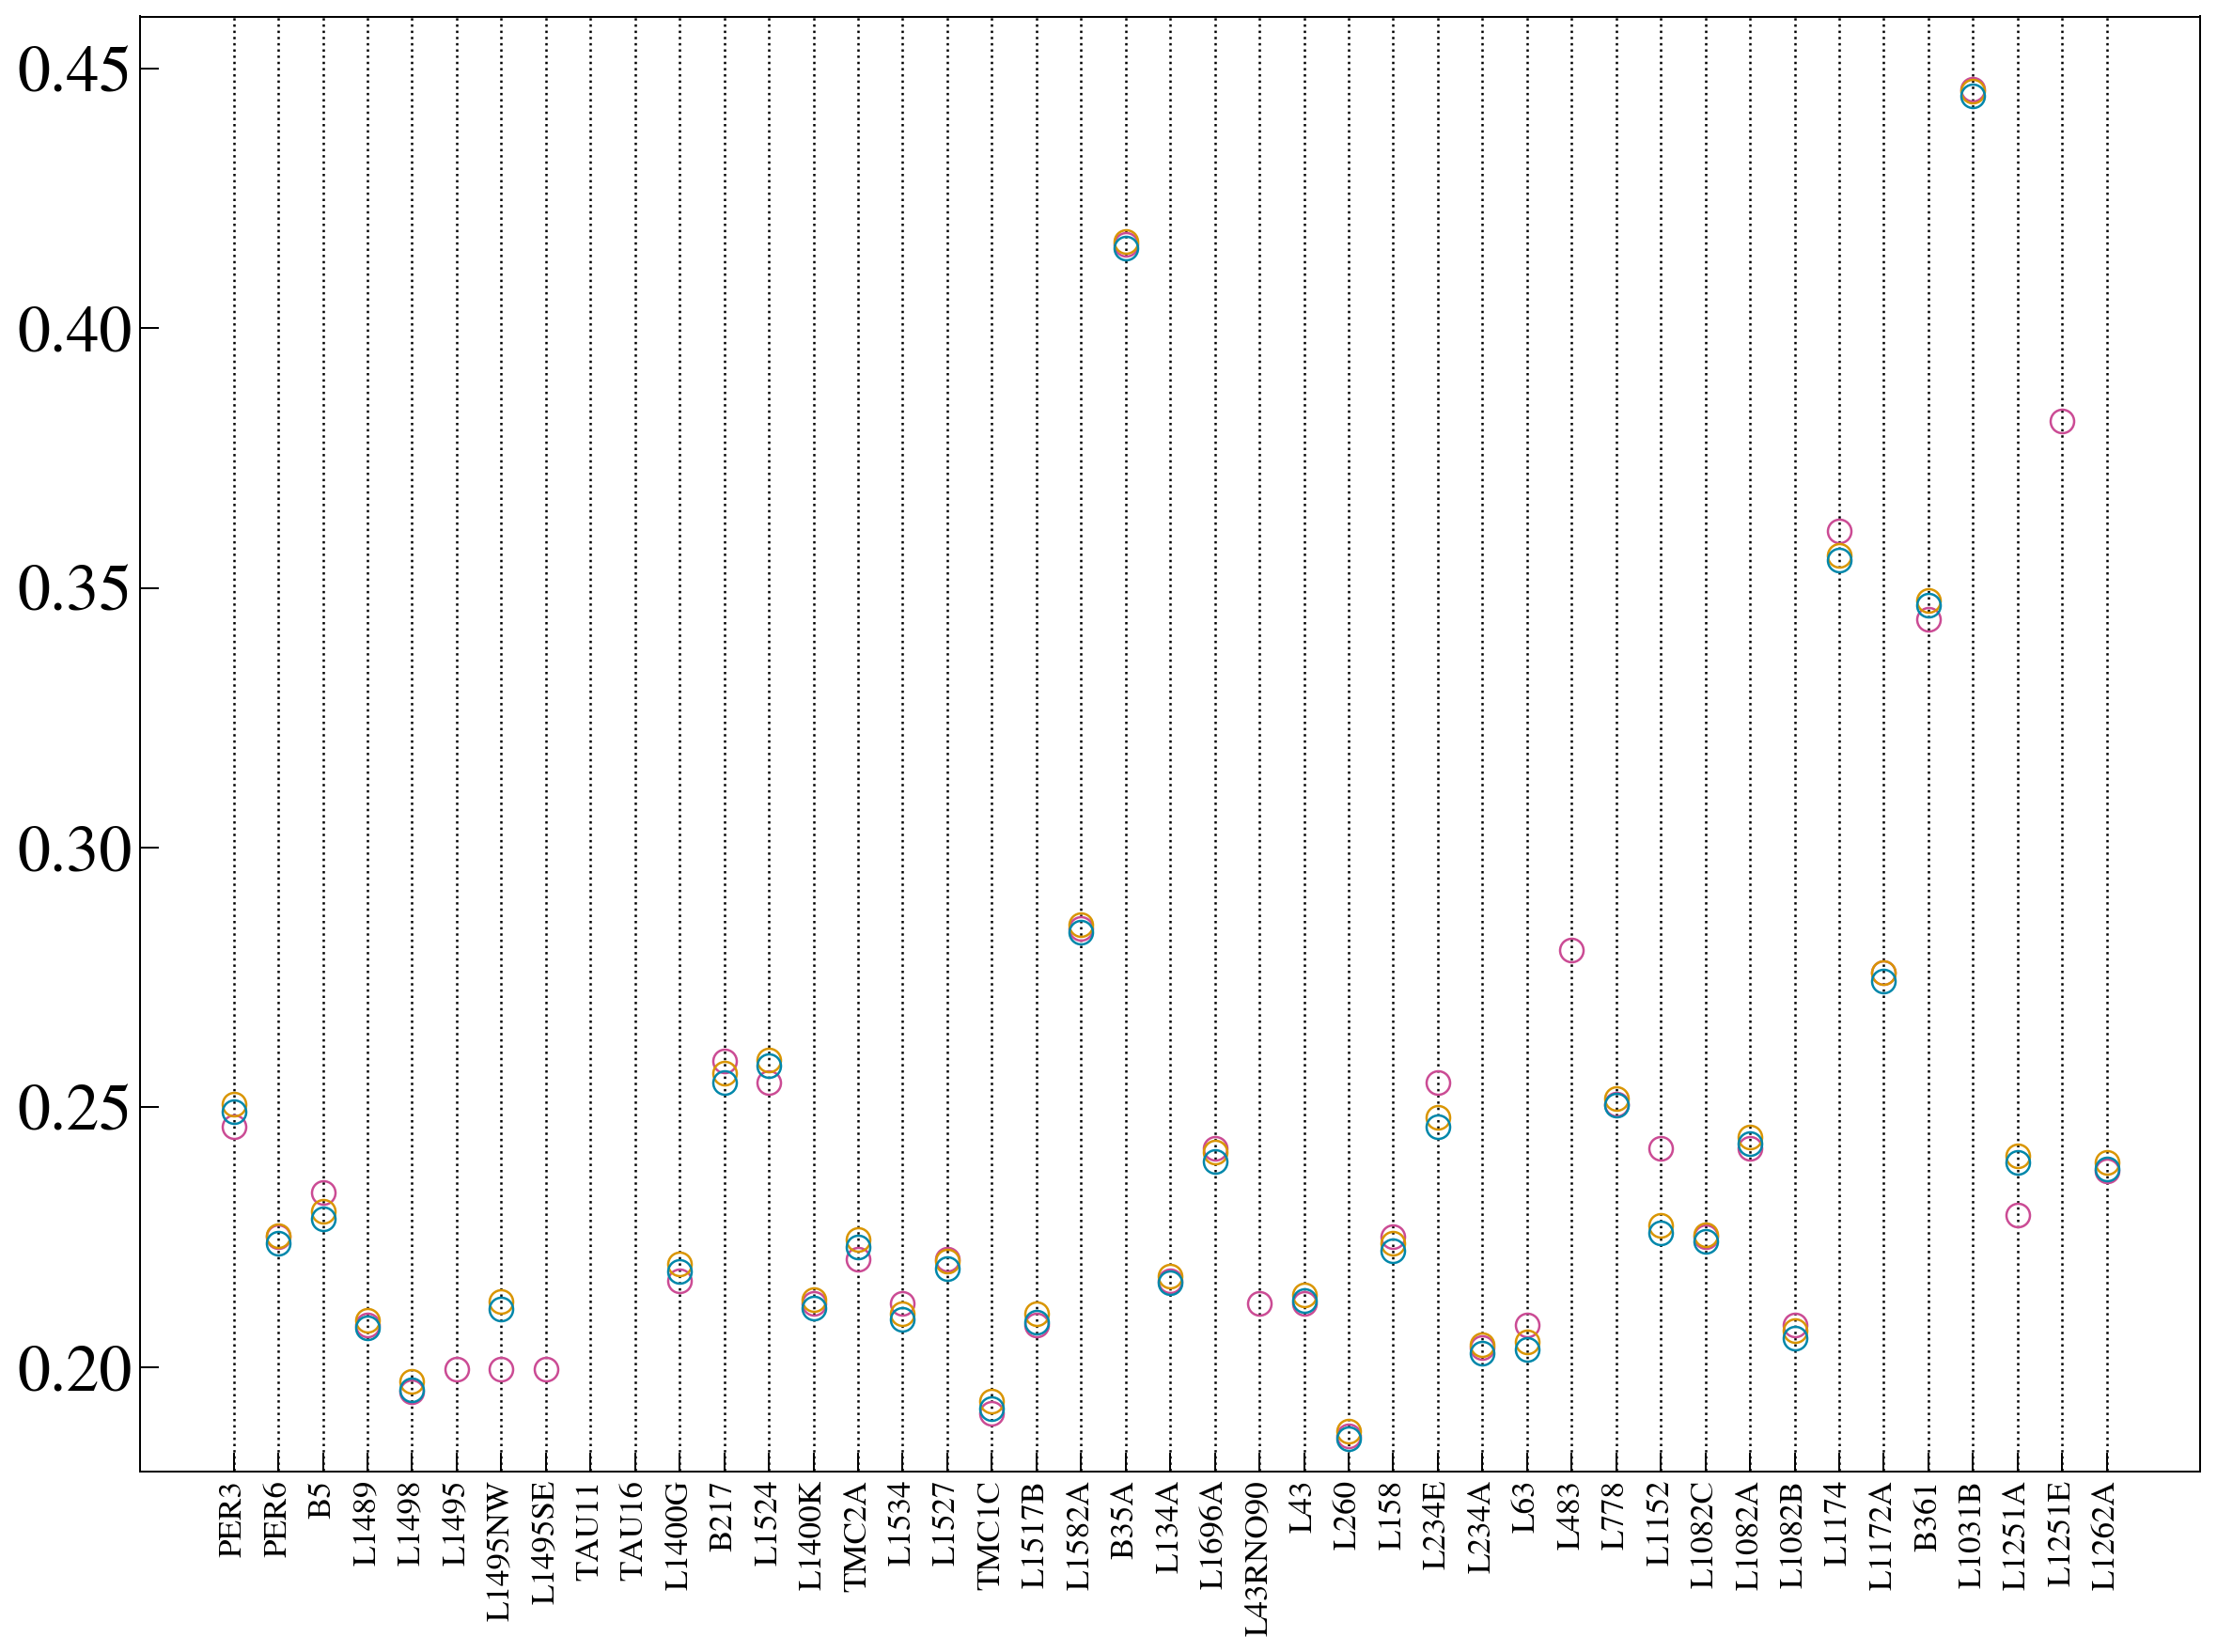

In [69]:
fig = plt.figure(figsize = (14., 10.))
ax = fig.gca()
ax.set_ylim(.18, .46)

ax.plot(SigmaTot0,
        linestyle = 'none',
        marker = '.',
        markeredgecolor = ssk_colors[3],
        markerfacecolor = 'none',
        lw = 1.)
ax.plot(SigmaTot1,
        linestyle = 'none',
        marker = '.',
        markeredgecolor = ssk_colors[4],
        markerfacecolor = 'none',
        lw = 1.)
ax.plot(SigmaTot2,
        linestyle = 'none',
        marker = '.',
        markeredgecolor = ssk_colors[5],
        markerfacecolor = 'none',
        lw = 1.)

ax.vlines(range(len(SigmaTot0)), *ax.get_ylim(),
          linestyle = ':')

ax.set_xticks(range(len(SigmaTot0)))
ax.set_xticklabels(table1_updated['ID'].values,
                   size = 14.,
                   rotation = 90)

In [135]:
table2_updated = table2.copy()

# gradient
table2_updated['Gradient'] = table2['Gradient']*(table1_updated['Distance']/table1['Distance'])**-1.
## uncertainty in G
table2_updated['eGradient'] = table2['eGradient']*(table1_updated['Distance']/table1['Distance'])**-1.

# beta
table2_updated['beta'] = table2['beta']*(2.37/2.33)**-1.*(table1_updated['Distance']/table1['Distance'])**-2.

# JoverM
## Note that J/M was calculated from ~ pGR^2, and does not depend on the mass.
table2_updated['JoverM'] = table2['JoverM']*(table1_updated['Distance']/table1['Distance'])


# Save to the folder.
direcData = os.getcwd()+'/data/Goodman93/'
table2_updated.to_csv(direcData+'table2_updated.csv',
                      index = False)

<a id='identification'></a>
## I. Identification of Structures

We look for coherent structures ([Goodman et al., 1998](https://ui.adsabs.harvard.edu/#abs/1998ApJ...504..223G/abstract)) in the L1688 region in Ophiuchus and the B18 region in Taurus.  [Goodman et al. (1998)](https://ui.adsabs.harvard.edu/#abs/1998ApJ...504..223G/abstract) proposed that these coherent structures represent the smallest scale in the self-similar process of star formation in turbulent clouds, within which the dominant gravity drives the final stage of star formation.  The coherent structures are defined by a boundary of sharp transition in linewidth, from supersonic linewidths outside to subsonic linewidths inside the coherent structures.  Thus, our selection and definition of target structures are based on comparison between the thermal ($\sigma_\text{T}$) and non-thermal ($\sigma_\text{NT}$) components of velocity dispersion.  We also look for coherent structures that also show a local peak in column density.

Note that [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract) did not impose a criterion regarding the velocity dispersion when selecting targets.  In this paper, since we intend to look for structures much smaller than the targets observed by [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract) and often more embedded within star forming regions, we try to avoid line of sight confusion by choosing only coherent structures.

[*The following code cell read in results that will be explained later in this notebook, including the masks for the target structures and the maps of predicted $V_\text{LSR}$ based on the velocity gradient fits.  The process of defining the boundary will be explained in [this section](#identification).  On the other hand, fitting of the velocity gradient is done in [the next section](#properties), and the maps of the predicted $V_\text{LSR}$ are read in here just for the ease of examination of how good a single linear velocity gradient could fit the $V_\text{LSR}$ field within each structure.*]
<a id='dict_masks'></a> <a id='dict_Vlsr_predicted'></a>

In [9]:
# directory to the masks
direcMasks = os.getcwd()+'/results/masks/'
dict_masks = {'L1688': {}, 'B18': {}}
# directory to the maps of predicted Vlsr
direcResults = os.getcwd()+'/results/Vlsr_predicted/'
dict_Vlsr_predicted = {'L1688': {}, 'B18': {}}

# Read in the maps.
for reg in ['L1688', 'B18']:
    if reg == 'L1688':
        listStructures = list(range(1, 13))+['extra']
    elif reg == 'B18':
        listStructures = range(1, 7)
        
    for structure in listStructures:
        ## masks
        dict_masks[reg][structure] = fits.open(direcMasks+reg+'/'\
                                               +reg+'_'+str(structure)+'.fits')[0].data.astype(bool)
        
        ## predicted Vlsr
        dict_Vlsr_predicted[reg][structure] = fits.open(direcResults+reg+'/'\
                                                        +reg+'_'+str(structure)+'_Vlsr_predicted.fits')[0].data

The quantitative criterion for defining the boundary of each target structure varies slightly from structure to structure, depending on the local environment each core sits in.  The boundary is built following the steps below:

1. <a id='step1'></a>Start with the contour where the NH$_3$ velocity dispersion, $\sigma_{\text{NH}_3}$, is equal to the velocity dispersion one would expect from when the velocity dispersion non-thermal component is the same as the sound speed of an average particle, $$\sigma_\text{NT} = c_\text{s, ave} \text{,}$$ at the median $T_\text{kin}$ measured in the targeted region (a rectangular box enclosing a potential structure).

2. <a id='step2'></a>If the contour forms a closed shape, and the shape contains a region with a condensed spatial distribution of the NH$_3$ (1, 1) peak main beam temperature, $T_\text{peak}$, and a constrained range of velocity centroids, $V_\text{LSR}$, then the contour is used to define the boundary of the structure.  This means that the boundary is coincident to either or both of the following: a) a significant increase in $T_\text{peak}$, or b) a significant change in $V_\text{LSR}$.

3. And, if the criteria in [Step 2](#step2) can be achieved by manually editing (adding or removing pixels from) the mask by less than 10% of the area, then the edited mask is used as the boundary of the structure.  

4. If the criteria in [Step 2](#step2) cannot be achieved by manually editing the mask, then a contour of constant $T_\text{peak}$ and/or a range of $V_\text{LSR}$ around the median velocity centroid in the original mask are used to define the structure.  This situation often happens when the original contour is too spatially extended or has a hole near the center of the target region.

5. Note that neither the *Herschel* column density map nor the *Herschel* dust temperature map is quantitatively used in defining the boundary.  The *Herschel* maps are but instead used to examine potential contamination from embedded sources, and to confirm that the boundary centers around a local rise in column density and a drop in dust temperature.

6. Lastly, the size of the resulting structure has to be larger than the size of the GBT beam at 23 GHz (~32") in both the R.A. and the Dec. directions.

As a result, we include 12 structures in L1688 and 6 structures in B18.  (See [Figure 1](#fig-droplet) for an example of such structure; see [Figure 2](#fig-skymaps) for all the structures in either region, plotted on top of several key property maps.)  There could potentially be more structures that satisfy the criteria above, but based on the GAS maps, these structures are probably more embedded in the star forming clusters and could suffer from contamination along the line of sight.  We include an "extra" structure in the L1688 region, which is isolated and has a clear velocity gradient, but does not have a subsonic linewidth.  This "extra" structure is include for the purpose of comparison.  Besides the "extra" structure, we number the structures following the guidelines recommended by the International Astronomical Union, in the increasing R.A. order (from West to East).

[**Figure 1.**](#fig-droplet)<a id='fig-droplet'></a> **Maps of the *Herschel* column density ($N_{\text{H}_2}$), the *Herschel* dust temperature ($T_\text{dust}$), the NH$_3$ peak main beam temperature ($T_\text{peak}$), the NH$_3$ velocity dispersion ($\sigma_{\text{NH}_3}$), the velocity centroids ($V_\text{LSR}$), and the predicted velocity centroid from a 2D linear fit to the observed velocities, of a target structure.**  The thick contour marks the boundary of the droplet in view.  The thin red contours on the $\sigma_{\text{NH}_3}$ map is where the NH$_3$ linewidth equals to the linewidth expected from a line with a sonic non-thermal component (see [Step 1 above](#step1)).  The star symbols denote the positions of Class 0/I and flat spectrum YSOs from the YSO catalogs ([Dunham et al., 2015](https://ui.adsabs.harvard.edu/#abs/2015ApJS..220...11D/abstract); [Rebull et al., 2010](https://ui.adsabs.harvard.edu/#abs/2010ApJS..186..259R/abstract)).  The GBT FWHM beam at 23 GHz is shown on the bottom left of each panel.  [***Change the code to view another structure.  The first input is the region ("L1688" or "B18"), and the second input is the structure number (from 1 to 12 for L1688; from 1 to 6 for B18; L1688 also has an "extra" core that does not satisfy all the criteria, but is include for comparison).  The static version of the plots can be found in the [github `./plots/droplets/` folder](https://github.com/hopehhchen/Droplets/tree/master/Droplets/plots/droplets).***]

[*The following code cell could generate a `RuntimeWarning` due to a conditional statement that compares the map of NH$_3$ linewidth, $\sigma_{\text{NH}_3}$, and the linewidth expected from when the non-thermal component is equal to the sound speed of an average particle, $\sigma_\text{NT} = c_\text{s, ave}$.  Such a comparison is invalid when the pixels have NaN values, where the pixels are flagged.  The plotting is wrapped in the `plotDroplet` function in [`Droplets.py`](https://github.com/hopehhchen/Droplets/blob/master/Droplets/Droplets.py), and please modify to your own taste.  The plots included in the paper are based on the plot generated in the same way, but with annotations made outside this ipython notebook (in macOS Keynote).*]

Droplets.py:353: RuntimeWarning: invalid value encountered in less
  axis.contour((list_images[i] < NT_sonic),
//anaconda/lib/python2.7/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


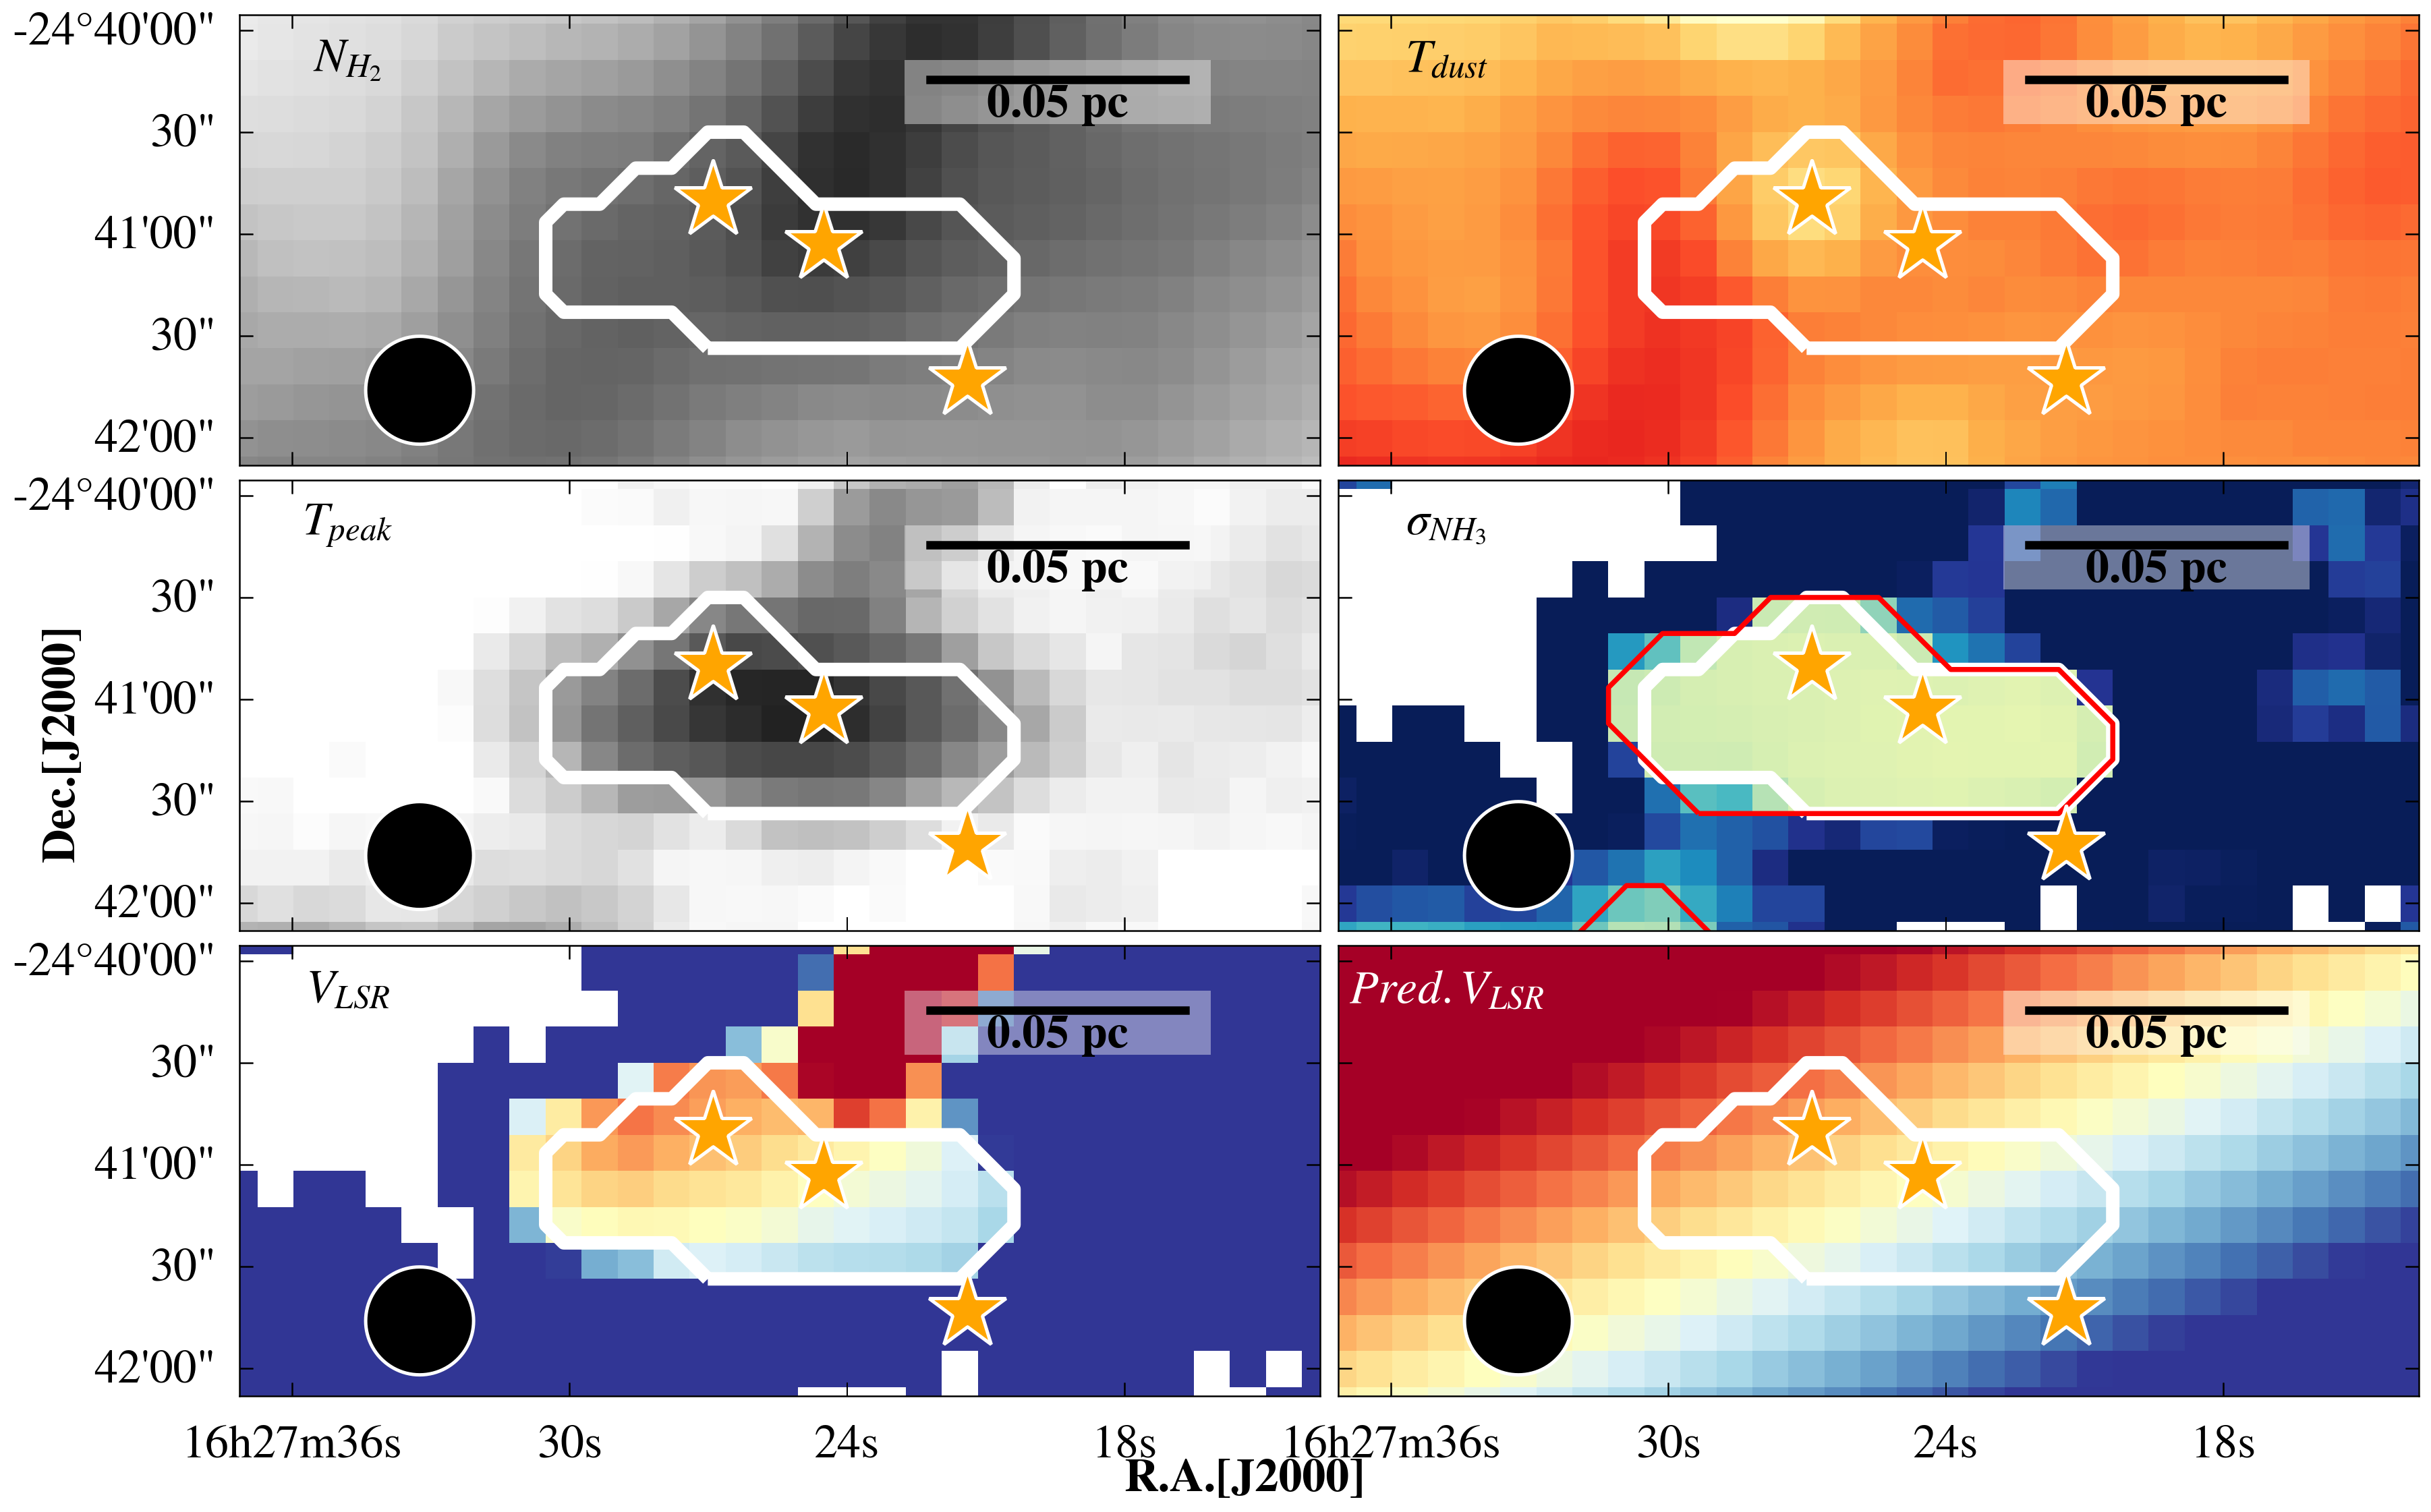

In [10]:
list_dictionaries = [dict_data, dict_masks, dict_YSOs, dict_Vlsr_predicted]
fig = plotDroplet('L1688', 6, list_dictionaries)  ## <<< Change the code in this line!

[**Figure 2.**](#fig-skymaps)<a id='fig-skymaps'></a> **Maps of the *Herschel* column density ($N_{\text{H}_2}$), the *Herschel* dust temperature ($T_\text{dust}$), the NH$_3$ peak main beam temperature ($T_\text{peak}$), the NH$_3$ kinetic temperature ($T_\text{kin}$), the velocity centroids ($V_\text{LSR}$), and the NH$_3$ velocity dispersion ($\sigma_{\text{NH}_3}$), of the entire region.**  The colored contours mark the boundaries of the droplets in the region.  The star symbols denote the positions of Class 0/I and flat spectrum YSOs from the YSO catalogs ([Dunham et al., 2015](https://ui.adsabs.harvard.edu/#abs/2015ApJS..220...11D/abstract); [Rebull et al., 2010](https://ui.adsabs.harvard.edu/#abs/2010ApJS..186..259R/abstract)).  The GBT FWHM beam at 23 GHz is shown on the bottom left of each panel.  *User's choice: A box could be plotted to highlight the region shown in [Figure 1](#fig-sroplet).*  [***Change the code to view either L1688 or B18 (the first input of the function "`plotRegion`".  Input a structure number to the variable "`chooseStructure`" to highlight the structure (from 1 to 12 for L1688; from 1 to 6 for B18; L1688 also has an "extra" core that does not satisfy all the criteria, but is include for comparison).  The static version of the plots can be found in the [github `./plots/regionMaps/` folder](https://github.com/hopehhchen/Droplets/tree/master/Droplets/plots/regionMaps).***]

[*The code for plotting this figure is wrapped in the `plotRegion` function in [`Droplets.py`](https://github.com/hopehhchen/Droplets/blob/master/Droplets/Droplets.py).*]

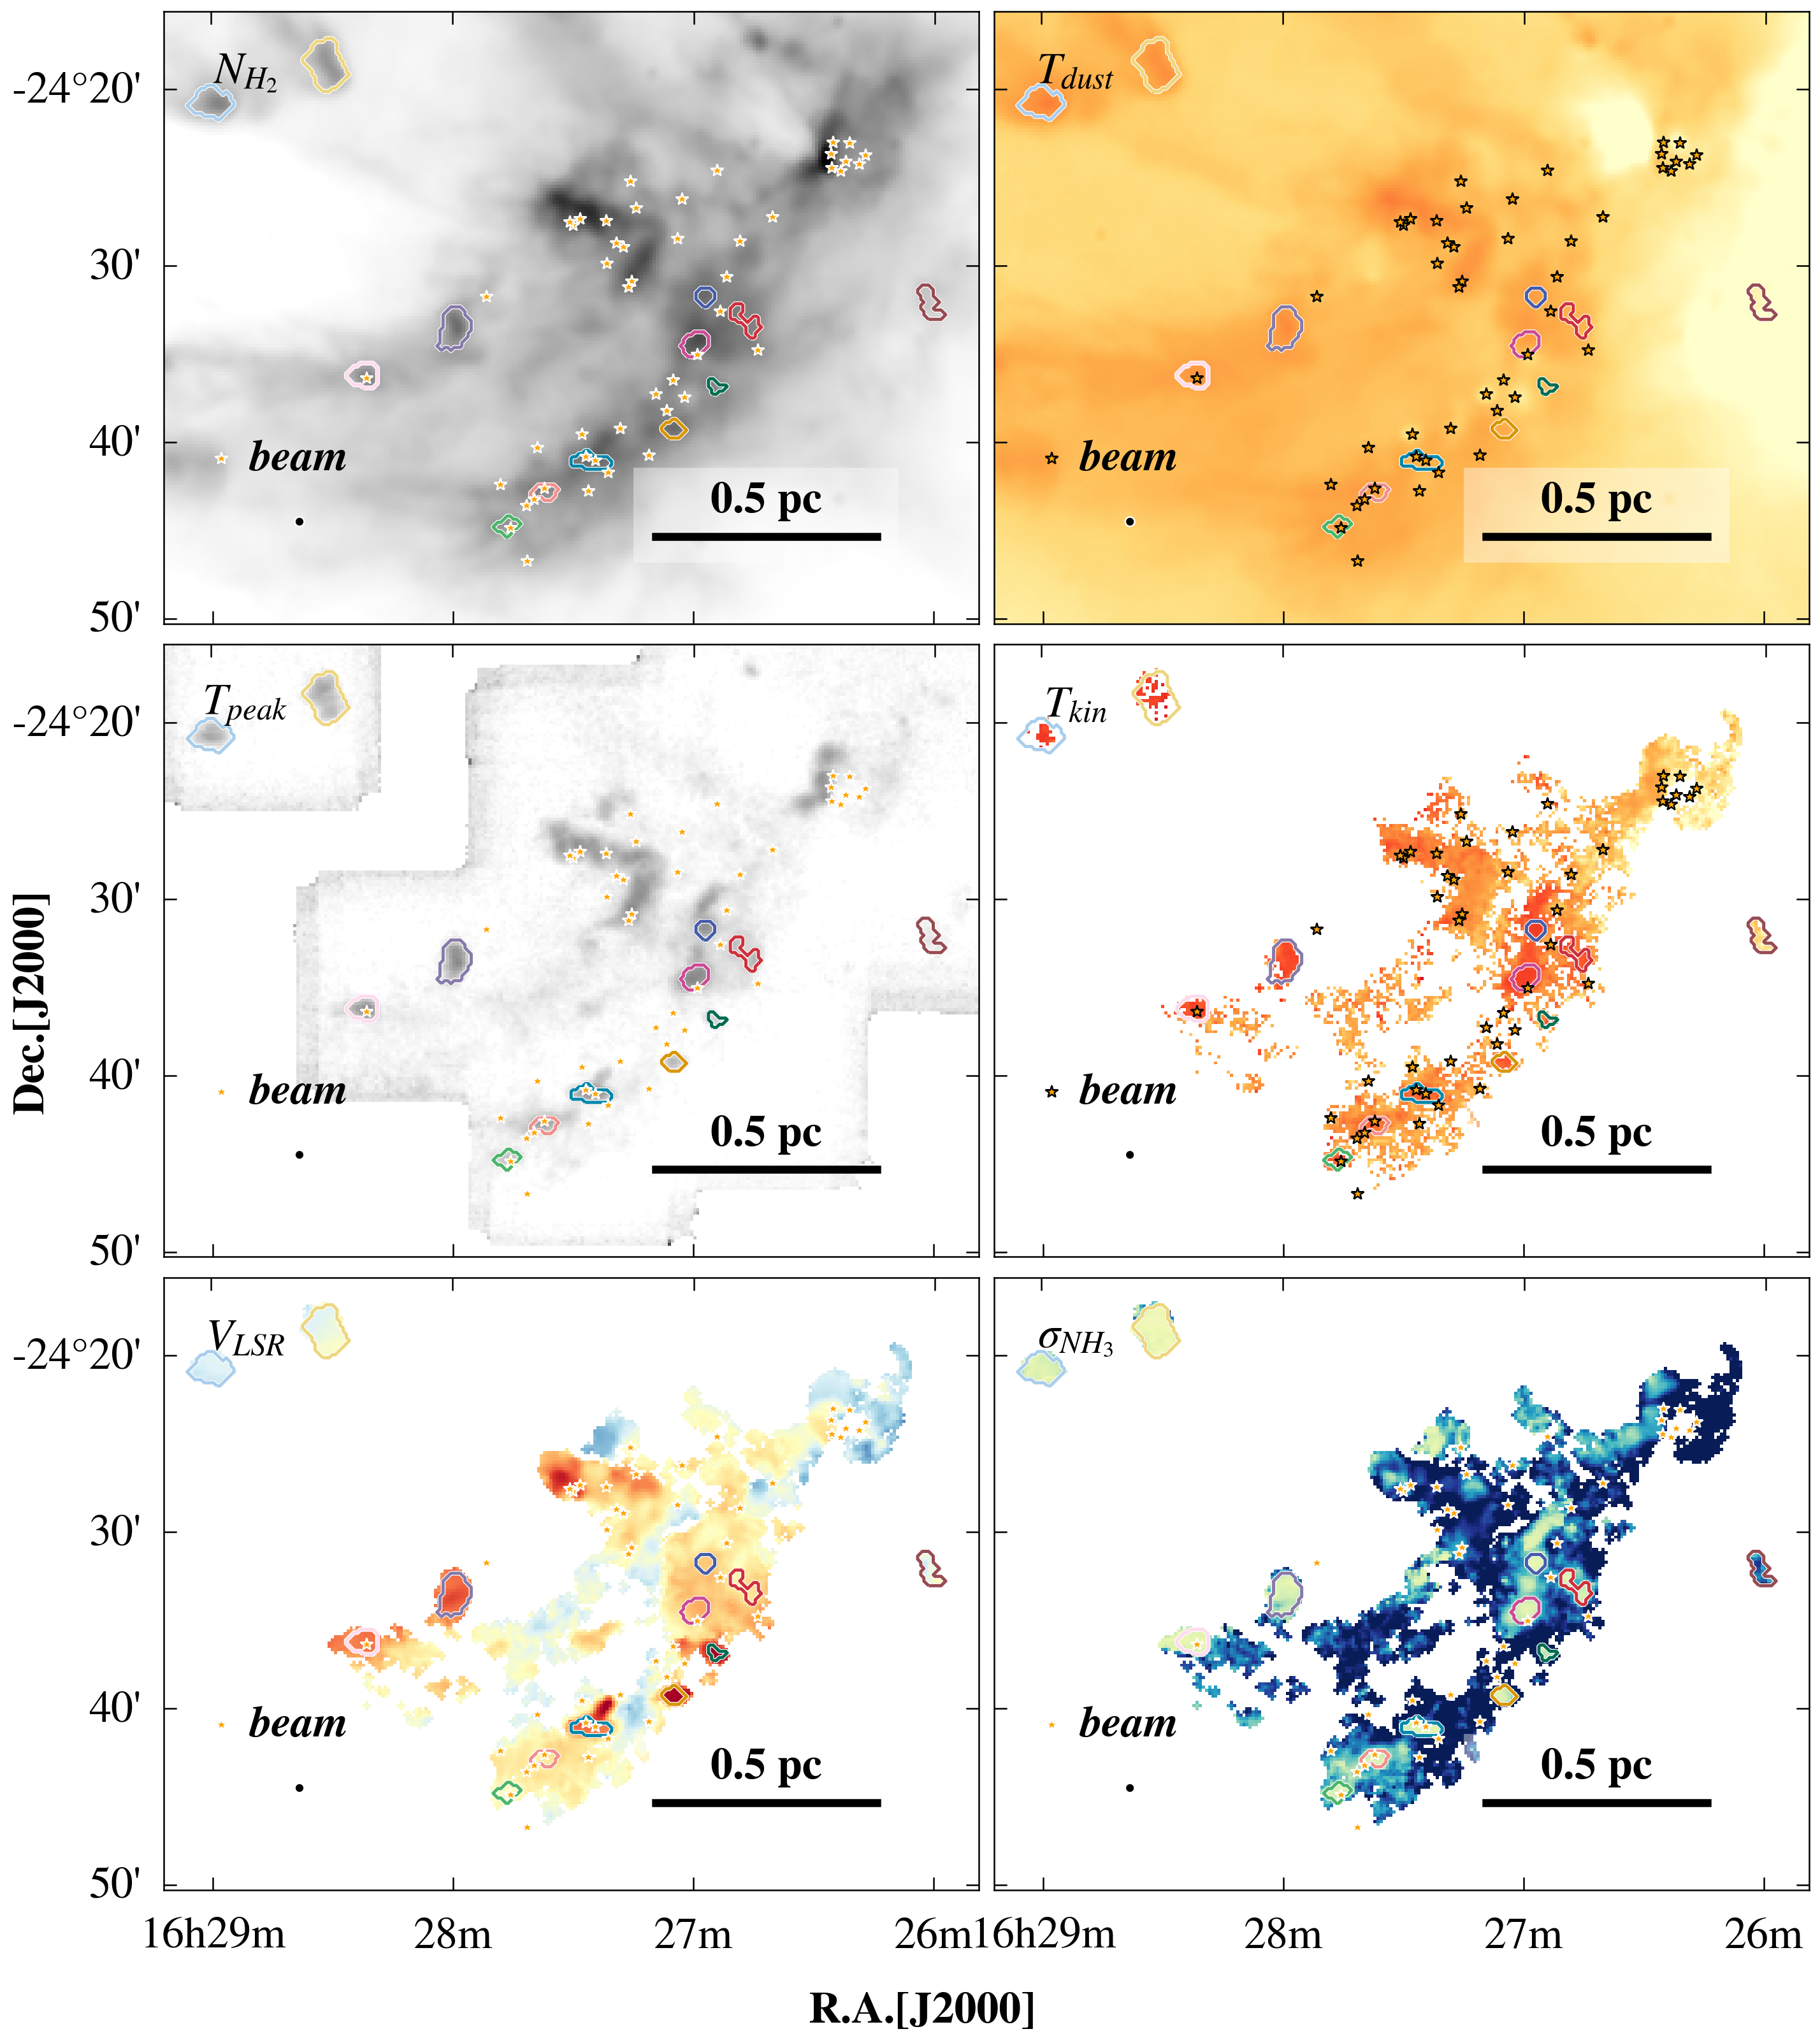

In [11]:
list_dictionaries = [dict_data, dict_masks, dict_YSOs, dict_Vlsr_predicted]
fig = plotRegion('L1688', list_dictionaries, chooseStructure = 6)  ## <<< Change the code in this line!

<a id='coherence'></a>
### I.1 The *Coherence* of the Structures

Since [Goodman et al. (1998)](https://ui.adsabs.harvard.edu/#abs/1998ApJ...504..223G/abstract), multiple attempts to observe the coherent cores have been made (for example, [Caselli et al., 2002](https://ui.adsabs.harvard.edu/#abs/2002ApJ...572..238C/abstract)).  As described in the previous paragraphs, one key property of such coherent cores is a sharp transition from supersonic velocity dispersion outside the core to subsonic velocity dispersion inside.  In the first direct observations of a coherent core in the B5 region in Perseus, [Pineda et al. (2010)](https://ui.adsabs.harvard.edu/#abs/2010ApJ...712L.116P/abstract) shows that the NH$_3$ velocity dispersion decreases with increasing peak antenna temperature around the coherent core ([Figure 4 in Pineda et al., 2010](http://www.astroexplorer.org/details/apjl340752f4)), with the increasing peak temperature serving as a proxy for increasing density.  Here we examine L1688 and B18 in similar plots of the NH$_3$ velocity dispersion, $\sigma_{\text{NH}_3}$, and the peak main beam temperature, $T_\text{peak}$, in [Figure 3](#fig-banana).  We find that a similar trend exists for the L1688 and B18 regions.  We also find that the target structures defined in [Section I](#identification) sits at the low velocity dispersion-high peak main beam temperature end of the trend, similar to the coherent core in B5 ([Pineda et al. (2010)](https://ui.adsabs.harvard.edu/#abs/2010ApJ...712L.116P/abstract)).

[**Figure 3.**](#fig-banana)<a id='fig-banana'></a> **$\sigma_{\text{NH}_3}$ as a function of $T_\text{peak}$, for both L1688 and B18.**  The colored dots are values measured at pixels inside the target structures, color coded correpondingly to the colors of contours in [Figure 2](#fig-skymaps); the gray dots represent the rest of the pixels.  The contours show the cumulative distributions, each of which encircles 25%, 50%, 75%, or 95% of the pixels.  The horizontal lines represent the expected NH$_3$ linewidths ($\sigma_{\text{NH}_3}$) when the non-thermal component ($\sigma_\text{NT}$) is equal to the sonic and half sonic speed ($c_\text{s,ave}$) of average particles, at $T_\text{kin} = 10\ K$. [***Change the `xscale` input to plot $T_\text{peak}$ on the logarithmic or the linear scale (`'log'` or `'linear'`).  The static version of the plots can be found in the [github `./plots/TpeakSigma/` folder](https://github.com/hopehhchen/Droplets/tree/master/Droplets/plots/TpeakSigma).***]

[*The code for plotting this figure is wrapped in the `plotTpeakSigma` function in [`Droplets.py`](https://github.com/hopehhchen/Droplets/blob/master/Droplets/Droplets.py).*]

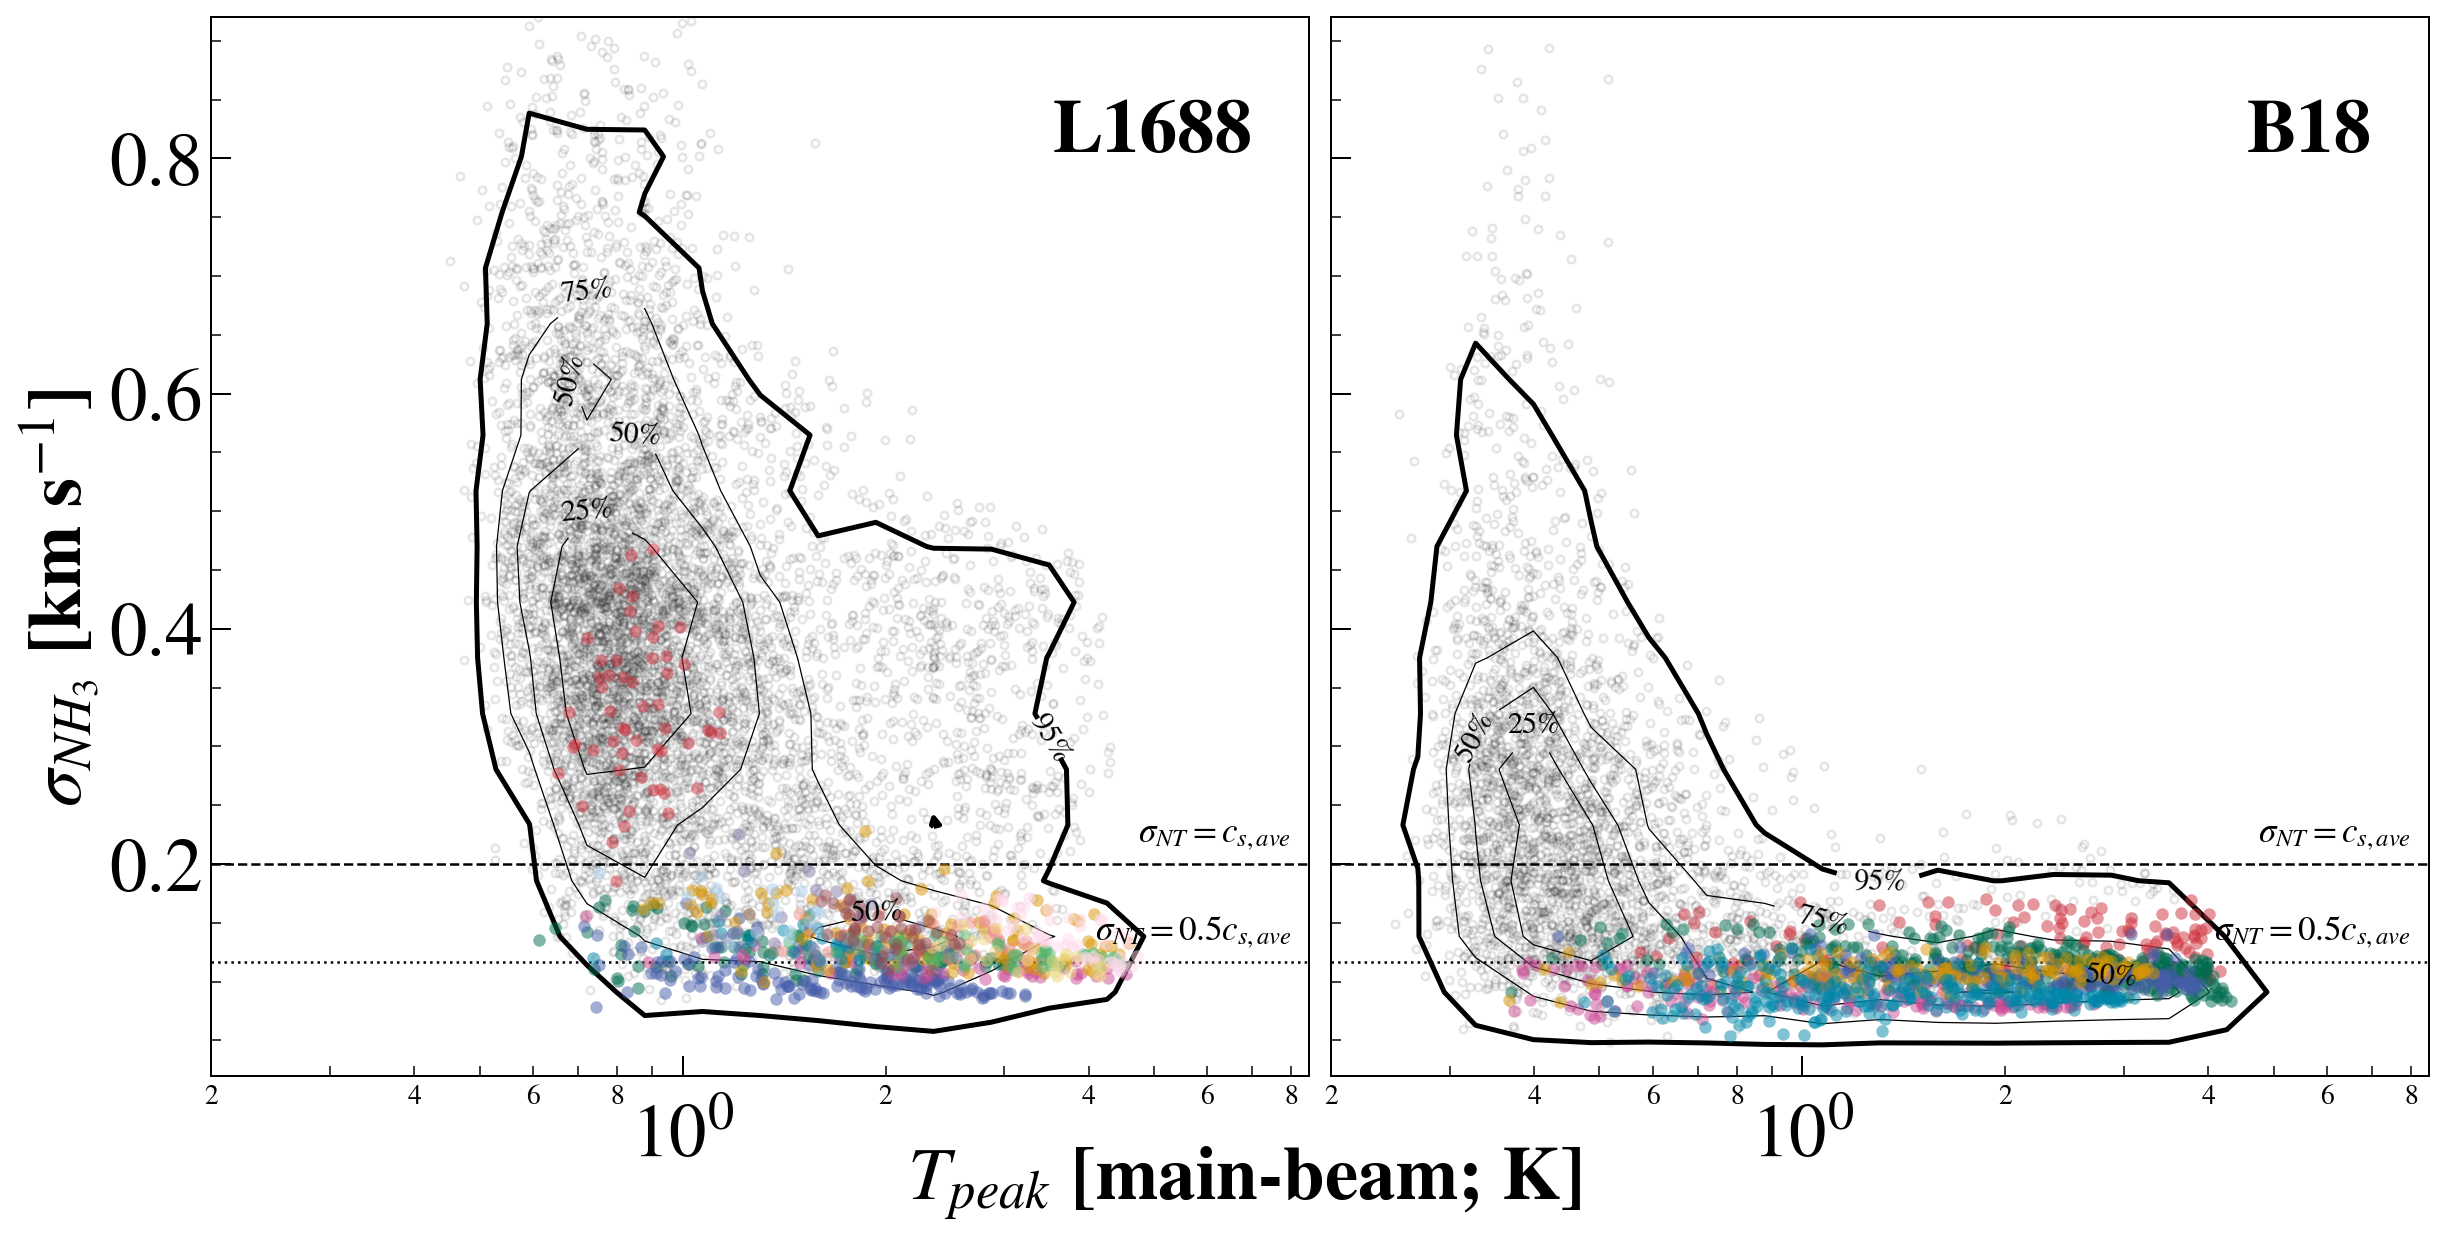

In [12]:
list_dictionaries = [dict_data, dict_masks, dict_YSOs, dict_Vlsr_predicted]
fig = plotTpeakSigma(list_dictionaries, xscale = 'log')  ## <<< Change the code in this line!

The radial profiles of found structures also demonstrate that these strcutures have subsonic velocity dispersions and show sharp transitions from supersonic to subsonic velocity dispersions at the edge where measurements are available (limited by the detection of NH$_3$ (1, 1) line emission; [Figure 4](#fig-sigmaProfile)).  And generally, the thermal component of the velocity dispersion is larger than the non-thermal component ([Figure 5](#fig-componentsProfile)), again, where the measurements are available.

[Friesen and Pineda et al. (2017)](https://ui.adsabs.harvard.edu/#abs/2017ApJ...843...63F/abstract) used the 3-$\sigma$ S/N level in the NH$_3$ (1, 1) line emission to mask out points with low detection levels/high uncertainties in the fitting of $\sigma_{\text{NH}_3}$, $V_\text{LSR}$, and $T_\text{ex}$; and added the 3-$\sigma$ S/N level in the NH$_3$ (2, 2) emission to mask out points with high uncertainties in the fitting of $T_\text{kin}$ and $N_{\text{NH}_3}$.  Since the calculation of $\sigma_\text{T}$ and $\sigma_\text{NT}$ requires both $\sigma_{\text{NH}_3}$ and $T_\text{kin}$, there are fewer available pixels where we have confident measurements of $\sigma_\text{T}$ and $\sigma_\text{NT}$.  This results in fewer solid dots found inside the effective radius in [Figure 5](#fig-componentsProfile).

[**Figure 4.**](#fig-sigmaProfile)<a id='fig-sigmaProfile'></a> **The radial profile of NH$_3$ velocity dispersion, $\sigma_{\text{NH}_3}$, of each structure.**  The solid green dots represent $\sigma_{\text{NH}_3}$ measured at pixels inside each structure, and the transparent green band shows 1-$\sigma$ distribution of $\sigma_{\text{NH}_3}$ measured at all pixels within each radius bin of a width $\sim0.01$ pc.  The horizontal dashed and dotted lines represent the expected $\sigma_{\text{NH}_3}$ when the nonthermal component equals to the sonic and half sonic speeds of average particles at $T_\text{kin} = 10\ K$, *i.e.* $\sigma_\text{NT}=c_\text{s,ave}$ and $\sigma_\text{NT}=0.5\ c_\text{s,ave}$.  The vertical line shows the effective radius, $R_\text{eff}$, of each structure, and the transparent gray band shows the uncertainty of $R_\text{eff}$.  Similar plots for the thermal and the non-thermal components ($\sigma_\text{T}$ and $\sigma_\text{NT}$) are shown in [Figure 5](#fig-componentsProfile).  The structure numbering is shown in the upper right corner.  [***The `plotSigma` input can be changed to plot the thermal and the non-therma components of the velocity dispersion, which is shown in [Figure 5](#fig-componentsProfile).  The static version of the plot can befound at the [github `./plots/Sigmas/` folder](https://github.com/hopehhchen/Droplets/tree/master/Droplets/plots/Sigmas).***]

[*The code for plotting this figure is wrapped in the `plotSigmas` function in [`Droplets.py`](https://github.com/hopehhchen/Droplets/blob/master/Droplets/Droplets.py).*]

//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
//anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


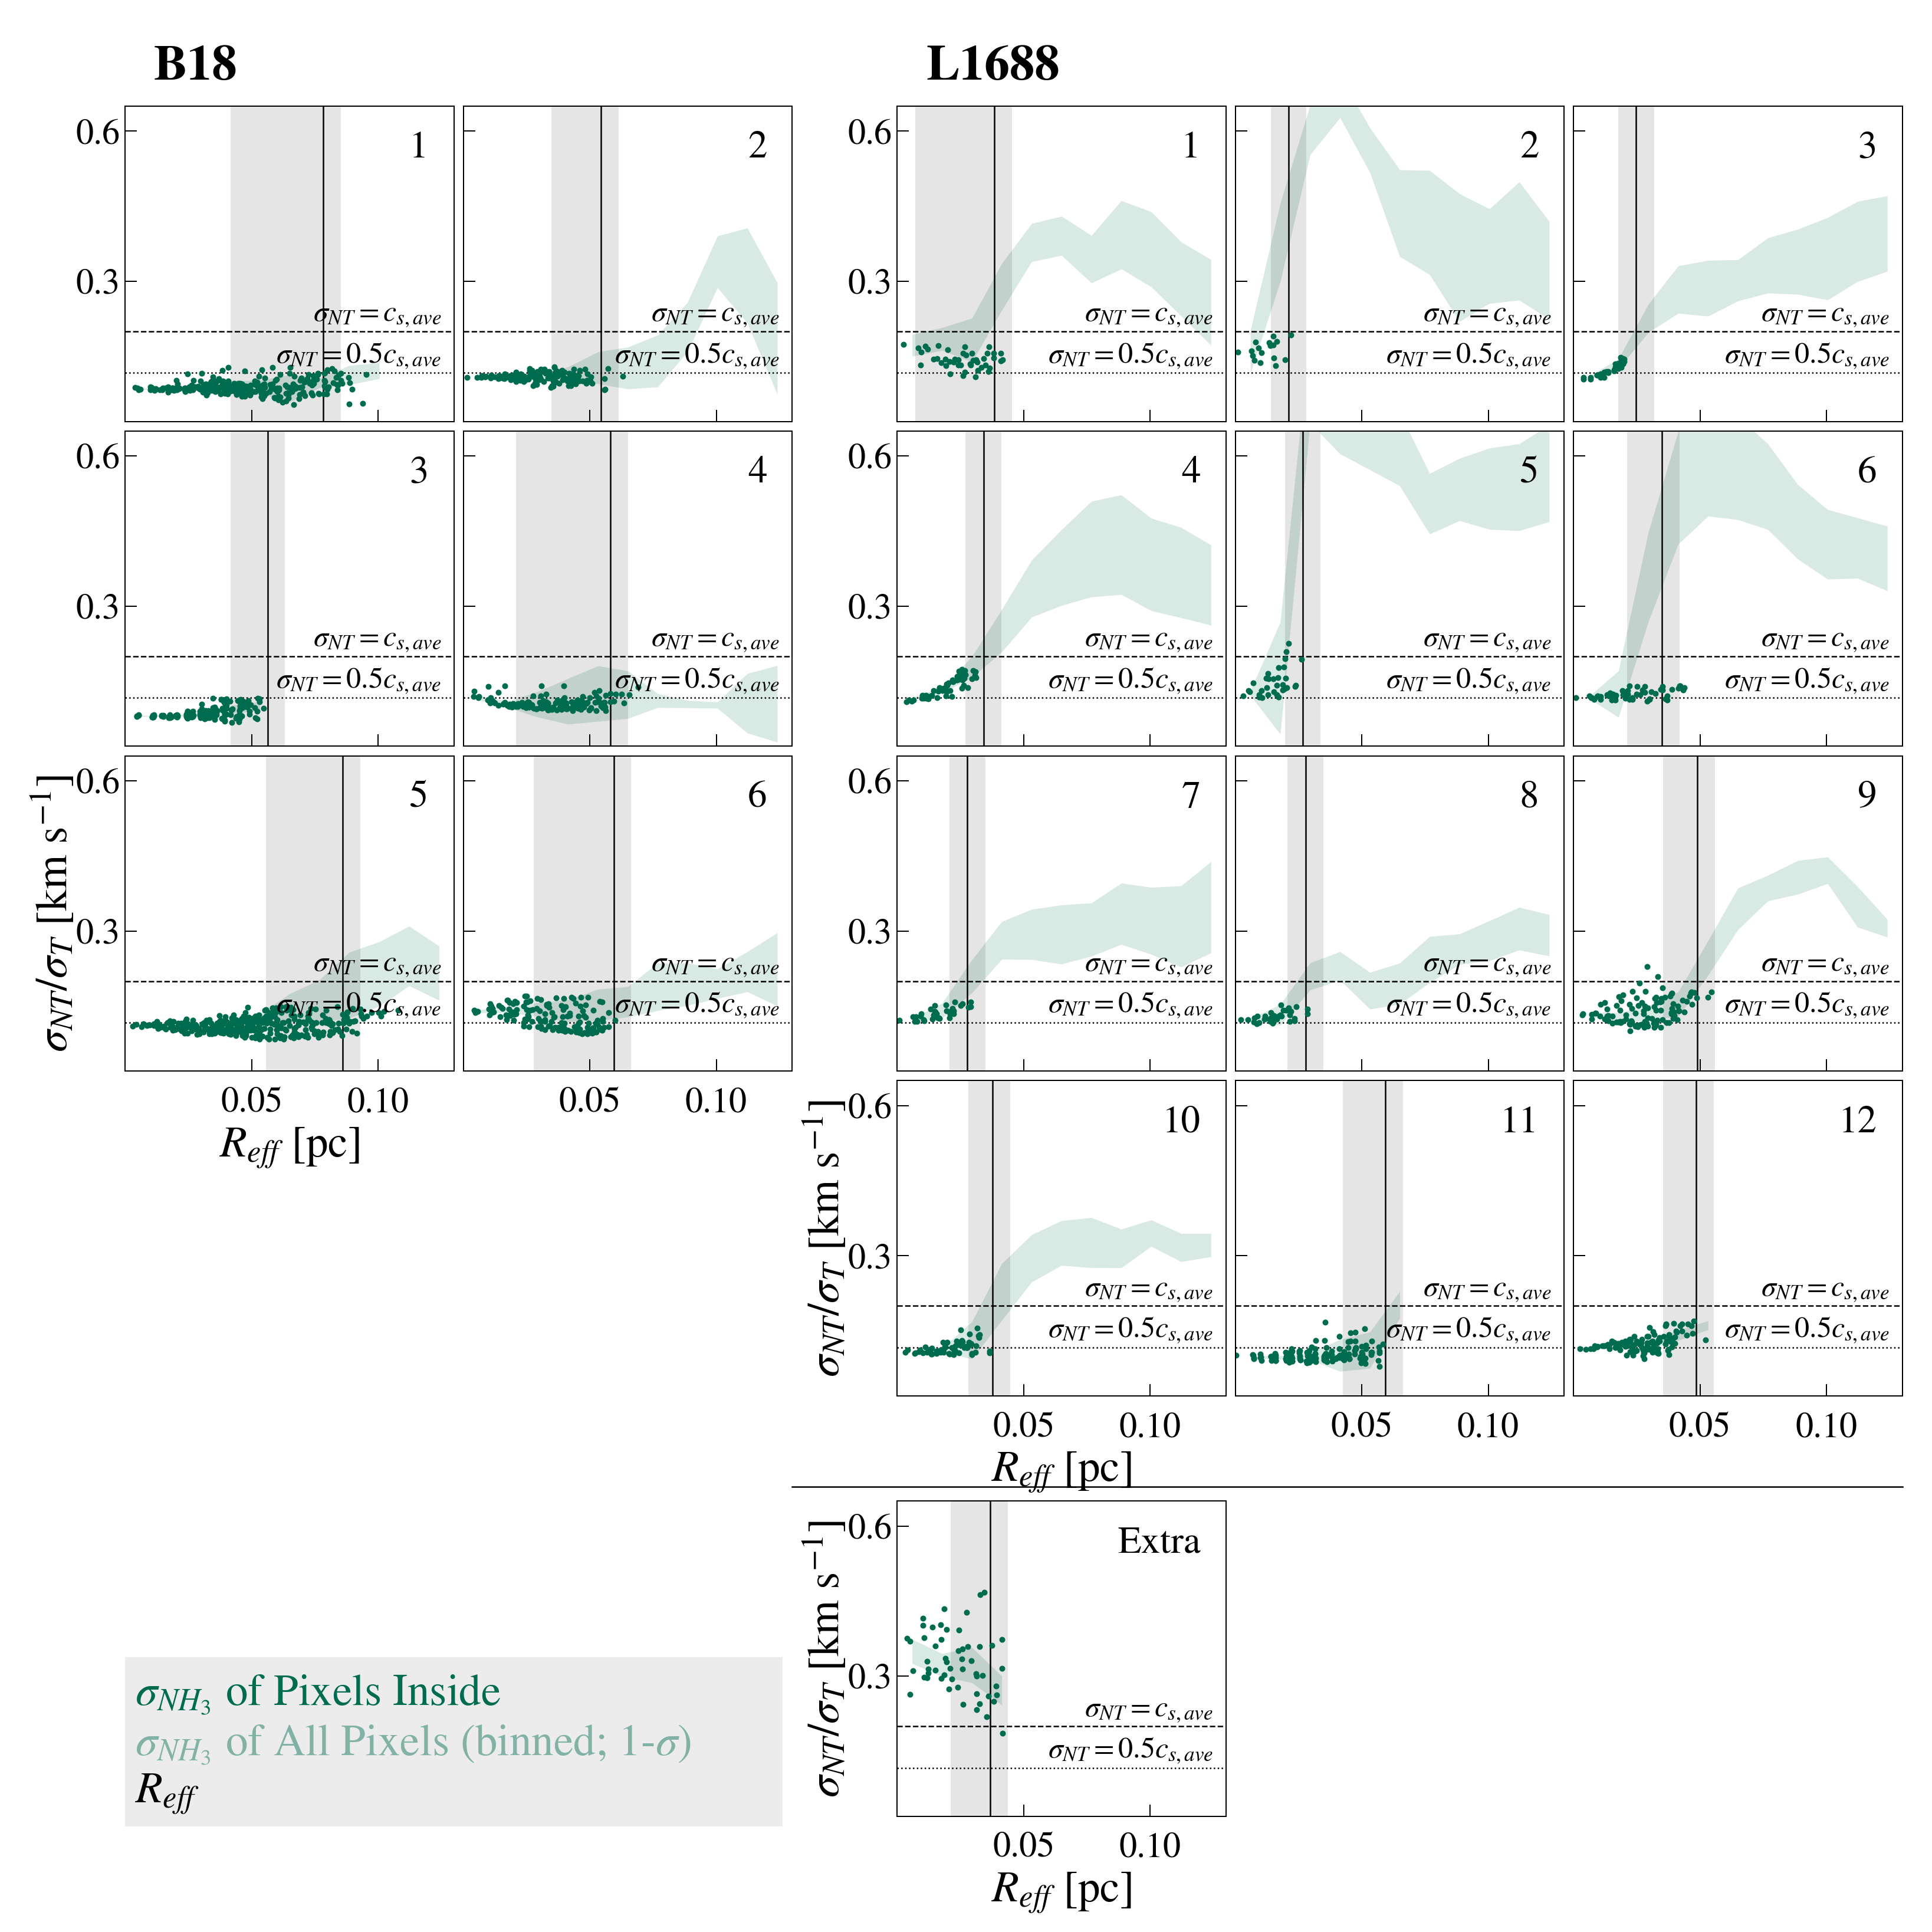

In [13]:
list_dictionaries = [dict_data, dict_masks, dict_YSOs, dict_Vlsr_predicted]
fig = plotSigmas(list_dictionaries, plotSigma = 'sigma', plotRfromA = False)## <<< See below for plotting components!

[**Figure 5.**](#fig-componentsProfile)<a id='fig-componentsProfile'></a> **Similar to [Figure 4](#fig-sigmaProfile), showing the profiles of the thermal and non-thermal components of velocity dispersion ($\sigma_\text{T}$ and $\sigma_\text{NT}$), of each structure.**  The solid red dots are $\sigma_\text{T}$ measured at pixels inside each structure, and the solid blue dots, $\sigma_\text{NT}$.  The transparent red and blue bands show 1-$\sigma$ distribution of $\sigma_\text{T}$ and $\sigma_\text{NT}$ measured at all pixels within each radius bin of a width $\sim0.01$ pc.  The horizontal dashed and dotted lines show the sonic and half sonic speeds of average particles at $T_\text{kin}=10\ K$.  (The sonic speeds are directly comparable to the thermal velocity dispresion, so they are plotted instead of the expected $\sigma_{\text{NH}_3}$.)  Similar to [Figure 4](#fig-sigmaProfile), the vertical line shows the effective radius of each structure.  The structure numbering is shown in the upper right corner.  [***The `plotSigma` input can be changed to plot the NH$_3$ velocity dispersion, which is shown in [Figure 4](#fig-sigmaProfile).  The static version of the plot can befound at the [github `./plots/Sigmas/` folder](https://github.com/hopehhchen/Droplets/tree/master/Droplets/plots/Sigmas).***]

[*The code for plotting this figure is wrapped in the `plotSigmas` function in [`Droplets.py`](https://github.com/hopehhchen/Droplets/blob/master/Droplets/Droplets.py).*]

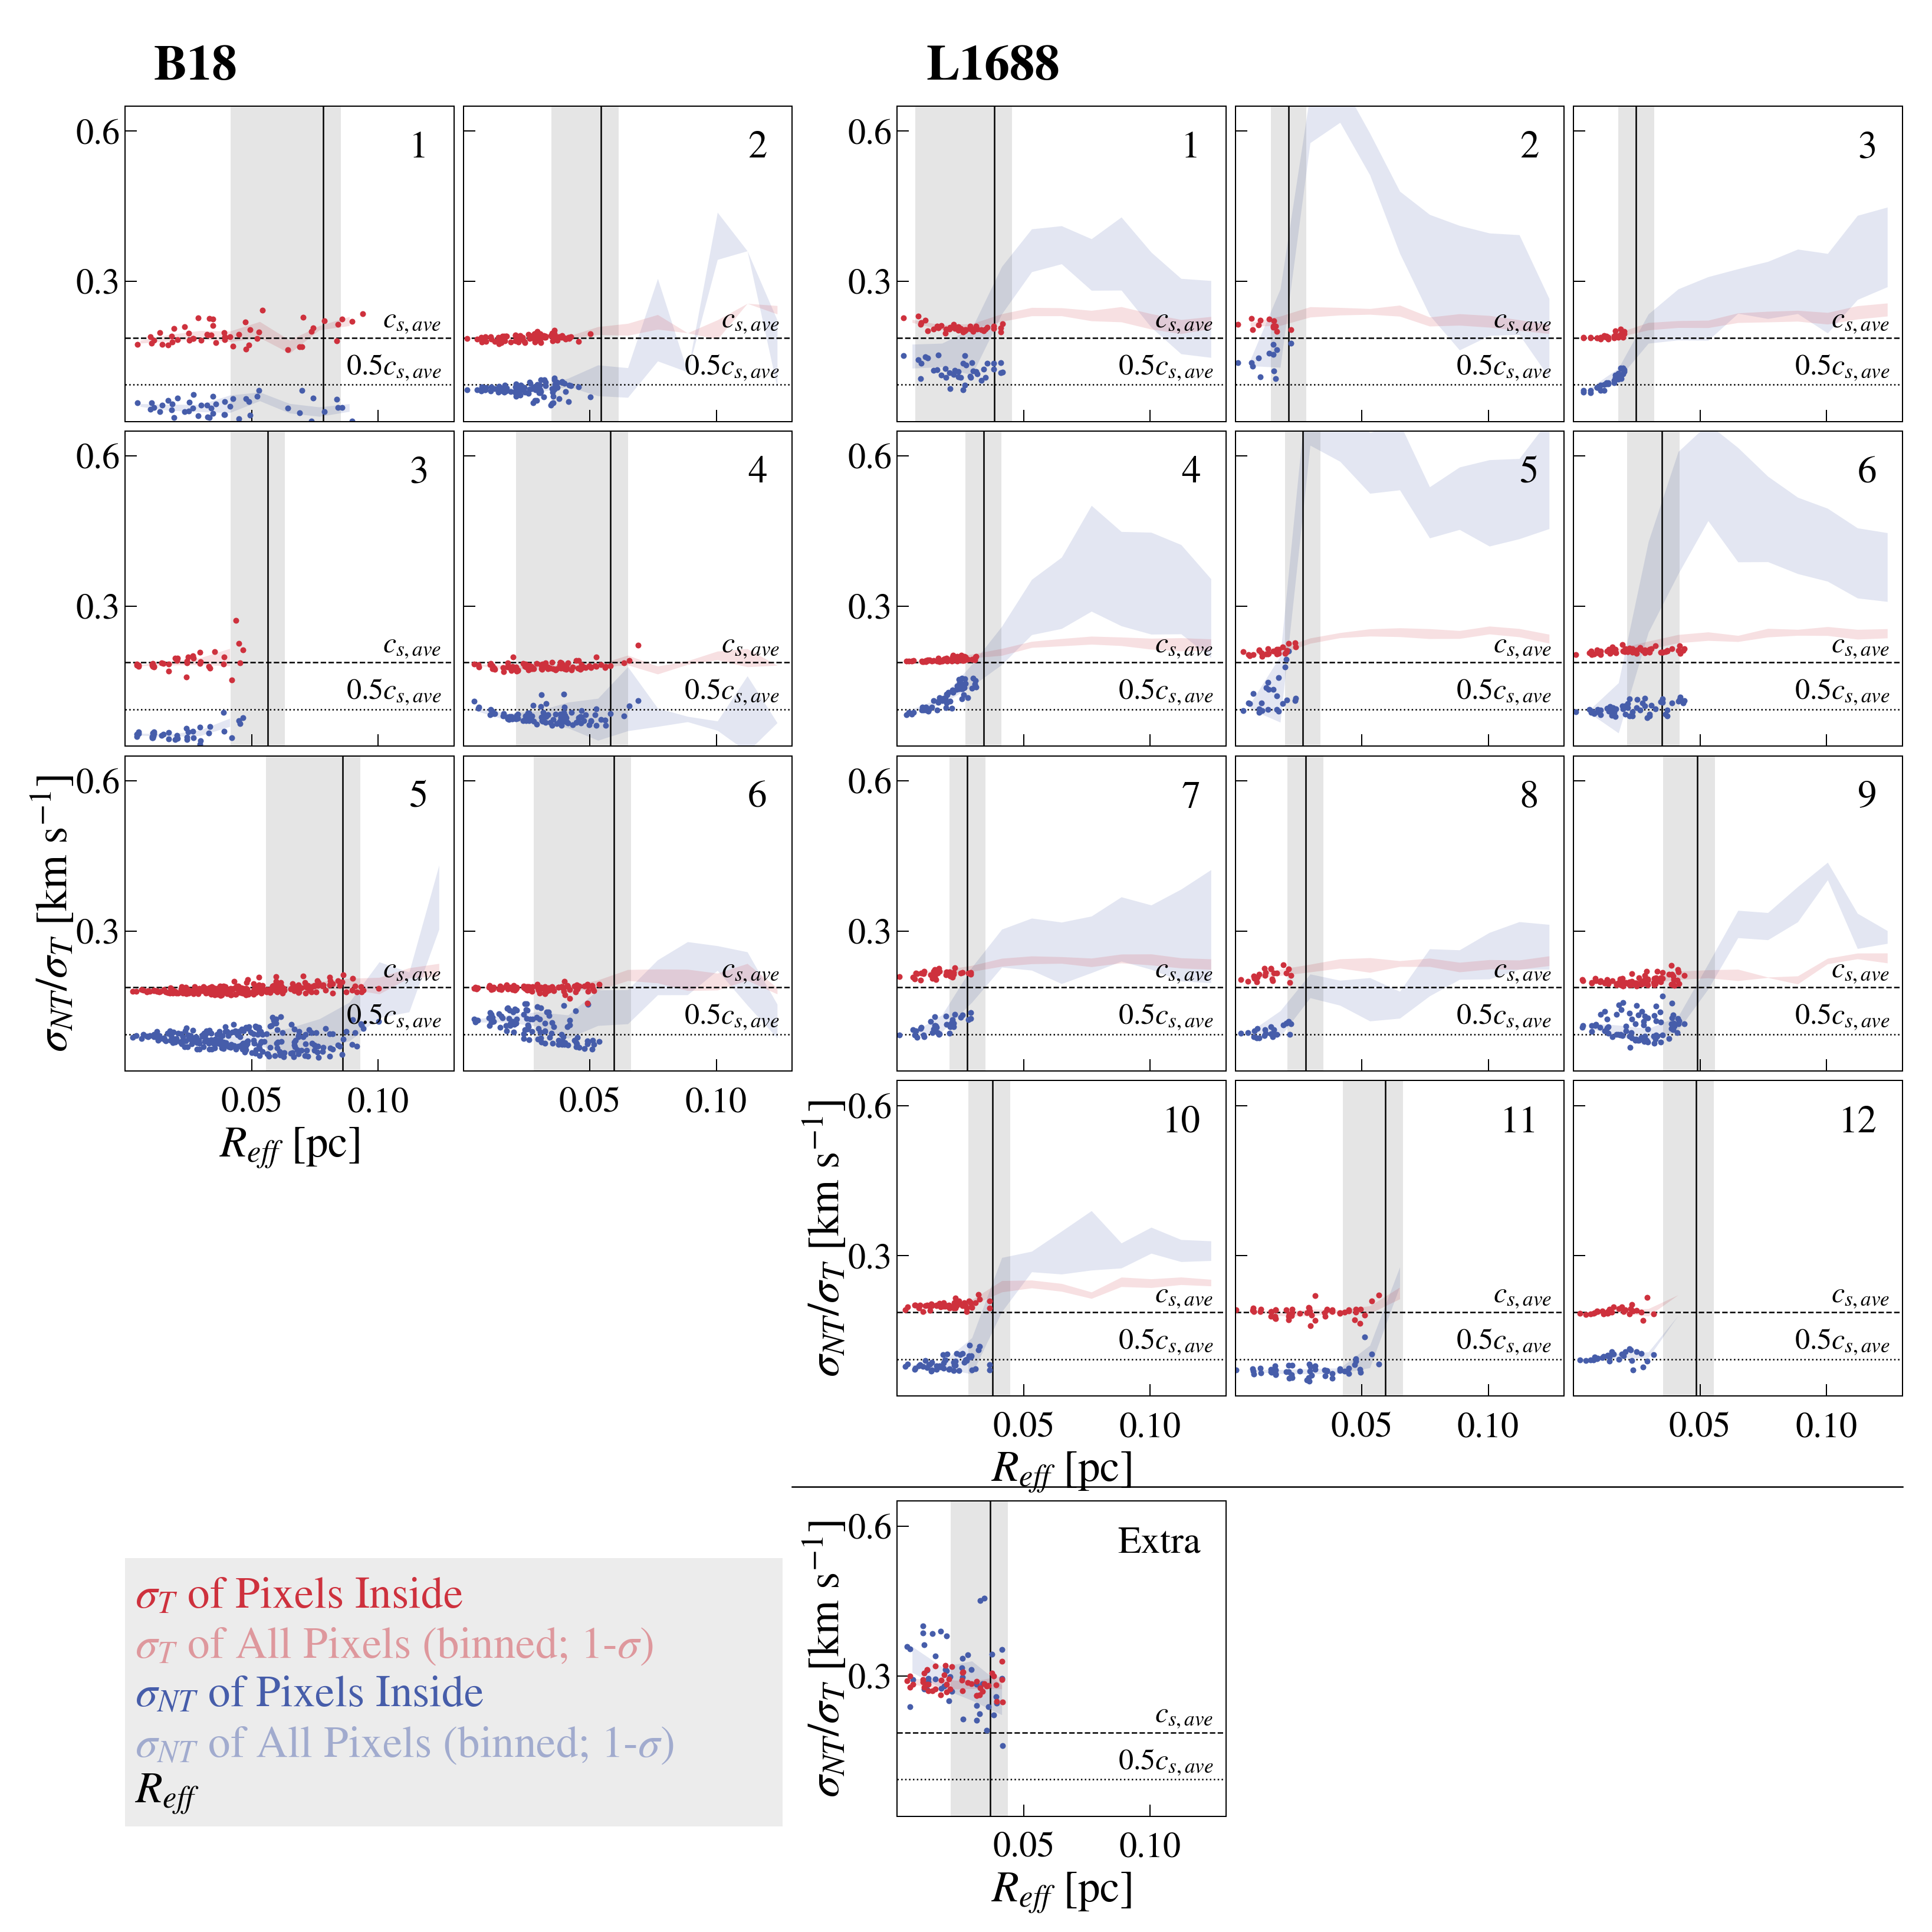

In [14]:
list_dictionaries = [dict_data, dict_masks, dict_YSOs, dict_Vlsr_predicted]
fig = plotSigmas(list_dictionaries, plotSigma = 'components', plotRfromA = False)## <<< See above for plotting sigma!

<a id='properties'></a>
## II. Physical Properties of Droplets

In [87]:
table1 = pd.read_csv(os.getcwd()+'/data/Goodman93/table1.csv',
                     index_col = False)
table2 = pd.read_csv(os.getcwd()+'/data/Goodman93/table2.csv',
                     index_col = False)

In [98]:
((10.**3.8*2.33*1.008*u.u*u.cm**-3)*(4./3.*np.pi*(0.45*u.pc)**3.)).to(u.Msun)/(140.*u.Msun)

<Quantity 0.9912770883396965>

In [99]:
((10.**3.8*2.37*u.u*u.cm**-3)*(4./3.*np.pi*(0.45*u.pc)**3.)).to(u.Msun)/(140.*u.Msun)

<Quantity 1.000292381703914>

In [103]:
((10.**4.5*2.33*1.008*u.u*u.cm**-3)*(4./3.*np.pi*(0.07*u.pc)**3.)).to(u.Msun)/(2.6*u.Msun)

<Quantity 1.006946356368497>

In [91]:
table1

ID  Distance           RA         Dec  Vlsr  FWHM      M  major  \
0       PER3       350   3h25m37.5s   30d55m20s   4.1  0.58   35.0   0.42   
1       PER6       350   3h27m10.3s   30d12m34s   5.8  0.53   20.0   0.24   
2         B5       350   3h44m28.7s   32d44m30s  10.2  0.55  140.0   0.72   
3      L1489       140    4h1m45.0s   26d11m33s   6.6  0.49    2.1   0.09   
4      L1498       140    4h7m50.0s    25d2m13s   7.8  0.46    0.8   0.07   
5      L1495       140    4h11m2.7s    28d1m58s   6.4  0.47    NaN   0.29   
6    L1495NW       140   4h10m44.5s    28d4m58s   6.1  0.47    4.0   0.23   
7    L1495SE       140    4h11m2.7s    28d1m58s   6.7  0.47    NaN   0.10   
8      TAU11       140   4h14m33.9s    27d56m0s   6.7   NaN    NaN   0.13   
9      TAU16       140   4h14m59.6s    28d15m0s   6.6   NaN    NaN   0.14   
10    L1400G       170   4h21m12.1s   54d52m20s   3.4  0.51    6.4   0.16   
11      B217       140   4h24m42.5s   26d11m13s   6.9  0.61    2.6   0.09   
12     L1524       140   4h26m26.0s   24d29m26s   6.5  0.60    1.2   0.10   
13    L1400K       170   4h26m51.0s   54d45m27s   3.2  0.50   14.0   0.31   
14     TMC2A       140   4h28m54.0s   24d26m27s   5.9  0.52    4.1   0.09   
15     L1534       140   4h36m31.2s   25d35m56s   6.3  0.50   13.0   0.18   
16     L1527       140   4h36m49.3s   25d57m16s   5.9  0.52    2.4   0.09   
17     TMC1C       140   4h38m34.5s    25d55m0s   5.2  0.45   20.0   0.25   
18    L1517B       140    4h52m7.2s   30d33m18s   5.7  0.49    0.7   0.07   
19    L1582A       435   5h29m11.9s   12d28m20s  10.2  0.67  150.0   0.53   
20      B35A       435   5h41m45.3s     9d7m40s  11.8  0.98   48.0   0.75   
21     L134A       100  15h50m58.1s   -4d26m36s   2.7  0.51   83.0   0.10   
22    L1696A       160  16h25m30.0s  -24d12m32s   3.3  0.57    6.1   0.17   
23  L43RNO90       160  16h31m46.3s  -15d40m50s   0.8  0.50    NaN   0.19   
24       L43       160  16h31m46.3s  -15d40m50s   0.7  0.50   53.0   0.19   
25      L260       160  16h44m22.3s    -9d30m2s   3.5  0.44   21.0   0.11   
26      L158       160  16h44m33.7s   -13d54m3s   3.9  0.53   33.0   0.38   
27     L234E       160  16h45m22.6s  -10d51m43s   3.0  0.60    0.6   0.09   
28     L234A       160  16h45m21.0s  -10d46m33s   2.9  0.48    4.8   0.13   
29       L63       160  16h47m21.0s    -18d1m0s   5.7  0.49    8.0   0.13   
30      L483       200  18h14m50.5s   -4d40m49s   5.5  0.66    NaN   0.17   
31      L778       200  19h24m26.4s   23d52m37s   9.9  0.59   39.0   0.19   
32     L1152       440  20h35m24.0s   67d43m53s   2.4  0.57   12.0   0.36   
33    L1082C       440  20h50m19.5s    60d7m40s  -2.6  0.53   24.0   0.29   
34    L1082A       440  20h52m20.7s    60d3m14s  -2.2  0.57  160.0   0.90   
35    L1082B       440  20h52m41.0s   59d58m19s  -2.3  0.49   19.0   0.29   
36     L1174       440  20h59m46.3s     68d1m4s   2.8  0.85  170.0   0.35   
37    L1172A       440   21h1m45.0s   67d42m13s   2.7  0.65    8.2   0.20   
38      B361       350  21h10m35.0s    47d12m1s   2.7  0.81   49.0   0.35   
39    L1031B       900  21h45m32.0s   47d18m13s   3.9  1.05  760.0   1.05   
40    L1251A       200  22h29m34.1s   74d58m51s  -4.0  0.54   32.0   0.41   
41    L1251E       200  22h38m11.7s   74d55m20s   0.3  0.90    NaN   0.36   
42    L1262A       200  23h23m32.2s    74d1m45s   3.9  0.56    3.3   0.15   

    minor  PA    AR  
0    0.10  48  0.24  
1    0.10  29  0.42  
2    0.29   8  0.39  
3    0.06 -39  0.67  
4    0.05 -46  0.72  
5    0.08 -50  0.29  
6    0.13 -50  0.55  
7    0.08 -40  0.83  
8    0.09  32  0.67  
9    0.08  29  0.59  
10   0.08 -60  0.48  
11   0.05  46  0.52  
12   0.07  17  0.71  
13   0.14  44  0.45  
14   0.07 -28  0.86  
15   0.11 -66  0.63  
16   0.07   8  0.81  
17   0.09 -49  0.37  
18   0.05  52  0.81  
19   0.25 -17  0.48  
20   0.29  21  0.39  
21   0.07 -11  0.71  
22   0.04  25  0.22  
23   0.10  73  0.51  
24   0.10 -87  0.51  
25   0.05  63  0.48  
26   0.18 -67  0.48  
27   

In [89]:
table1.keys()

Index([u'ID', u'Distance', u'RA', u'Dec', u'Vlsr', u'FWHM', u'M', u'major',
       u'minor', u'PA', u'AR'],
      dtype='object')

In [90]:
table2.keys()

Index([u'ID', u'Gradient', u'eGradient', u'Direction', u'eDirection',
       u'GradientToUncertainty', u'GradientR', u'beta', u'JoverM'],
      dtype='object')

In [41]:
dict_Vlsr_predicted = {'L1688': {}, 'B18': {}}

for reg in ['L1688', 'B18']:
    if reg == 'L1688':
        listCores = list(range(1, 13))+['extra']
    elif reg == 'B18':
        listCores = range(1, 7)
    header = dict_data[reg]['header_GAS']
        
    for core in listCores:
        mask = dict_masks[reg][core]
        Vlsr, eVlsr = dict_data[reg]['Vlsr'], dict_data[reg]['eVlsr']
        
        Vlsr_predicted = fitGradient(mask, Vlsr, eVlsr)[2]  ## `fitGradient` function is in `Droplets.py`.
        dict_Vlsr_predicted[reg][core] = Vlsr_predicted